# **Proyecto 03 - Series de Tiempo**

**Dataset: Flujo Vehicular por Unidades de Peaje AUSA**

## **Objetivo** 

**El objetivo del proyecto es estimar la demanda de autopista Illia para el 4T de 2019, medida en cantidad de peajes abonados en efectivo, mediante modelos predictivos de series de tiempo.** Para ese fin, trabajaremos con los datos de 2017 al 2019 inclusive, para esa estación de peaje y ese medio de pago.

La estrategia consiste en evaluar el desempeño de distintos modelos mediante el RMSE y el MAPE. En todos los casos, hablamos de modelos univariados, dónde la única variable independiente es el tiempo, y la variable dependiente son la cantidad de pasos (cantidad de peajes).

## *Business Understanding*

Personas se trasladan por trabajo o trabajando, para hacer trámites, están en viaje de vacaciones, por estudio, para visitar amigos o familia, hacer compras, ocio, y demás. Un completo universo de individuos se traslada. Este interminable e intermitente movimiento, creciente con el tiempo (me aventuro), define una característica de la modernidad. Somos cambientes y flexibles. No dormimos dónde trabajamos. No descansamos dónde vivimos. No trabajamos en un sólo lugar, ni acumulamos parientes o amistades en zonas geográficas. Las oportunidades (y la vida) están donde estan, y vamos tras ellas. 

Nos movemos. Pero no todos por igual. Hay patrones, algunos bastante obvios. A primera hora, hacia nuestros trabajos, principalmente. Al final de la tarde, el regreso. Los fines de semana, o en temporada de verano e invierno, por ocio. Tambien viajamos por trámites, para ver profesionales de la salud, especialistas, etc. 

Cambia el costo del peaje, del estacionamiento, de la patente, de la VTV, y/o del combustible. Algunos deciden carpolling, otros deciden no subir a la autopista, o sólo para ir o volver. A veces pagamos en efectivo. Nos modernizamos y usamos abonos. Se crea nueva infraestructura (PDB). Se crean o destruyen días feriados. Equipos de fúltbol disputan partidos internacionales, o no entran en las copas (o no hay eliminatorias para seleccionados nacionales). No viajamos (o sí) si hay votación.

Este sostenido incremento en la movilidad puede generar congestión. Que calles chicas requieran ser avenidas. Que avenidas acaben insuficientes, y requiramos autopistas. Todo ello, para no perecer en interminables y agotadores traslados, desde, o hacia. Pero, porque siempre hay un pero, la autopista no está exenta de sus propios conflictos. Uno de ellos, quizás de los más relevantes, es el tiempo que pasamos detenidos en los pejaes, un tema que tiene incidencia desde el campo de lo ambiental (emisiones), económico (incremento en el consumo de combustible), y hasta en las percepciones individuales de bienestar (tiempo perdido). Según se lee en la página del Gobierno de la Ciudad de Buenos Aires, las personas que suben a las autopistas llegan a perder hasta un día al año detenidos en peajes. En estos terminos, el objetivo debería ser minimizar el volumen de peajes abonados con medios de pago manuales.   

La digresión precedente (despunte del vicio), invita a formularnos preguntas sobre escenarios futuros: 
- ¿Cómo será la demanda de uso de autopista en el futuro?
- ¿Será suficiente la infraestructura actual para contener el flujo vehícular en los próximos años?
- En base a su evolución, ceteris paribus, ¿en qué momento podría llegarse a punto de congestión?
- En caso de necesitarse, ¿es técnicamente posible modificar infraestructura de transporte, o se requerirá de alternativas vinculadas a desarrollo urbano?
- ¿Que medidas o eventos pueden estimular la migración hacia medios de pagos automáticos (telepase)?

## Variables que impactan en el uso de autopistas

Si bien hemos realizado revisión de papers, lo que sigue es una simple enumeración de variables que asumimos (a veces documentado) tienen impacto en la demanda de uso de autopistas. No pretende ser un estudio exhaustivo, dadas las características del proyecto.

- cuestiones climáticas
- tarifas
- demografía
- variación relativa en el costo de las propiedades (Zona Norte vs. CABA)
- Costo del combustible
- Costo de estacionamiento
- Existencia de peajes urbanos

# **Análisis Exploratorio de Datos**

In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import datetime
sns.set()

from fbprophet import Prophet

In [2]:
def with_hue(plot, feature, Number_of_categories, hue_categories):
    a = [p.get_height() for p in plot.patches]
    patch = [p for p in plot.patches]
    for i in range(Number_of_categories):
        total = feature.value_counts().values[i]
        for j in range(hue_categories):
            percentage = '{:.1f}%'.format(100 * a[(j*Number_of_categories + i)]/total)
            x = patch[(j*Number_of_categories + i)].get_x() + patch[(j*Number_of_categories + i)].get_width() / 2
            y = patch[(j*Number_of_categories + i)].get_y() + patch[(j*Number_of_categories + i)].get_height() 
            ax.annotate(percentage, (x, y), size = 12, ha = 'center', xycoords = 'data') 
    

def without_hue(plot, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12, ha ='center' , xycoords = 'data')

In [3]:
data_2019 = pd.read_csv('flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('flujo-vehicular-2017.csv', sep =',')

## *Explorando los datasets*

In [4]:
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  hora_fin     dia    estacion    sentido  \
0     2019  2019-01-01            0         1  Martes     Alberti     Centro   
1     2019  2019-01-01            0         1  Martes     Alberti     Centro   
2     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
3     2019  2019-01-01            0         1  Martes     Alberti  Provincia   
4     2019  2019-01-01            0         1  Martes  Avellaneda     Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              22  
1       Liviano    TELEPASE               6  
2       Liviano  NO COBRADO              53  
3       Liviano    TELEPASE              18  
4       Liviano    EFECTIVO              16

In [5]:
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  hora_fin    dia estacion sentido  \
0     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
1     2018  2018-01-01            0         1  Lunes  Alberdi  Centro   
2     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
3     2018  2018-01-01            1         2  Lunes  Alberdi  Centro   
4     2018  2018-01-01            2         3  Lunes  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              29  
1       Liviano    TELEPASE               9  
2       Liviano  NO COBRADO              73  
3       Liviano    TELEPASE              39  
4       Liviano  NO COBRADO             115

In [6]:
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  hora_fin      dia estacion sentido  \
0     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
1     2017  2017-01-01            0         1  Domingo  Alberdi  Centro   
2     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
3     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   
4     2017  2017-01-01            1         2  Domingo  Alberdi  Centro   

  tipo_vehiculo  forma_pago  cantidad_pasos  
0       Liviano  NO COBRADO              25  
1       Liviano    TELEPASE               7  
2       Liviano  NO COBRADO               5  
3       Liviano    EFECTIVO               2  
4       Liviano    EFECTIVO              94

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [7]:
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [8]:
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [9]:
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [10]:
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']


**Podemos decir entonces que los años 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:**

- **periodo**: año del dset 

- **fecha**: año dia mes

- **hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

- **hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

- **dia**: dia de la semana 

- **estacion**: Observamos que 'Dellepiane Centro' (sólo es sentido centro) y 'Dellepiane Liniers' (sólo es sentido Provinca), son unificadas en 2019. Las unificaremos para todo el dataset. Lo mismo para el cambio de nombre de la estación Alberdi (2017 y 2018) a 'Alberti' (2019), lo cuál asumimos un error en la denominación en los dataset. Dejaremos esta última. También se agrega PDB en 2019.

- **sentido**: Centro o Provincia

- **tipo_vehiculo**: Liviano o Pesado

- **forma_pago**: Hay varias y varian entre los años.

- **cantidad_pasos**: Cantidad de vehiculos

## Acondicionando el dataset preliminar

Vamos a iniciar contextualizando a la autopista Illia frente al resto, para el conjunto de atributos. Más adelante realizaremos el filtrado del dataset según el objetivo del proyecto. 

Vamos a concatenar los años, pasar la fecha a datetime, y unificarla con hora_fin. De esta forma, nos podemos deshacer más adelante de los atributos 'período', 'hora_inicio' y 'hora_fin'.

Finalmente, unificamos las estaciones Dellepiane para todo el período, y las formas de pago 'TARJETA DISCAPACIDAD' con 'T. DISCAPACIDAD'

In [11]:
#Unimos los 3 datasets. Podemos hacerlo asi directamente, ya que tienen las mismas columnas
dataset = pd.concat([data_2017, data_2018, data_2019])

#Nos quedamos solamente con la estación Illia; de momento dejamos todas las formas de pago Efectivo para realizar el AED
#mask = dataset.estacion=='Illia'
#dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
#dataset.drop(columns = ['periodo','hora_inicio'], inplace = True)

#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha'], inplace = True)

#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 

#Reemplazamos categorias para homogeneizar el dataset
dataset.replace({'TARJETA DISCAPACIDAD': 'T. DISCAPACIDAD', 'Dellepiane Centro': 'Dellepiane', 
                 'Dellepiane Liniers': 'Dellepiane', 'Alberdi': 'Alberti'}, inplace=True)
dataset.head(5)

periodo  hora_inicio  hora_fin      dia estacion sentido tipo_vehiculo  \
0     2017            0         1  Domingo  Alberti  Centro       Liviano   
1     2017            0         1  Domingo  Alberti  Centro       Liviano   
2     2017            1         2  Domingo  Alberti  Centro       Liviano   
3     2017            1         2  Domingo  Alberti  Centro       Liviano   
4     2017            1         2  Domingo  Alberti  Centro       Liviano   

   forma_pago  cantidad_pasos               fecha  
0  NO COBRADO              25 2017-01-01 01:00:00  
1    TELEPASE               7 2017-01-01 01:00:00  
2  NO COBRADO               5 2017-01-01 02:00:00  
3    EFECTIVO               2 2017-01-01 02:00:00  
4    EFECTIVO              94 2017-01-01 02:00:00

In [12]:
dataset.shape

(3560706, 10)

El dataset contiene 3560706 registros con 10 atributos

## Flujo vehicular en contexto

Empecemos por caracterizar el flujo vehicular en las autopistas de AUSA.

### Flujo vehicular según estación, por año

In [13]:
dataset.groupby([dataset.estacion, dataset.periodo])['cantidad_pasos'].sum()#.plot(kind='pie')#.sort_values()#

estacion    periodo
Alberti     2017        5789514
            2018        5734842
            2019        5631401
Avellaneda  2017       50811590
            2018       49652369
            2019       48303625
Dellepiane  2017       30693934
            2018       29762844
            2019       29295448
Illia       2017       33570584
            2018       34490038
            2019       34155167
PDB         2019        5668376
Retiro      2017        2352828
            2018        1398682
            2019        1170450
Salguero    2017         616828
            2018         952055
            2019        1221380
Sarmiento   2017         998212
            2018        1102862
            2019        1264678
Name: cantidad_pasos, dtype: int64

Hay peajes que descienden todo el período (), mientras otros siguen el movimiento inverso (Sarmiento, Salguero). La estación Illia crece en peajes en 2018 frente a 2017, pero retrocede parcialmente en 2019. Vamos a mirar la participación de cada estación para la ventana de tres años, con especial foco en Illia

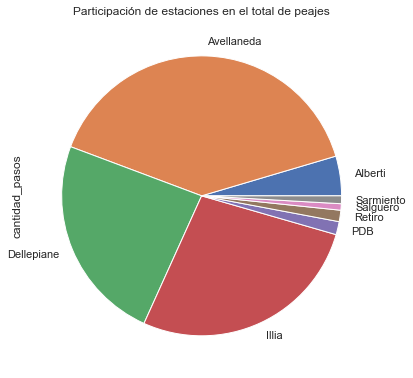

In [14]:
ax= dataset.groupby([dataset.estacion])['cantidad_pasos'].sum().plot(kind='pie', figsize=(12,6), title='Participación de estaciones en el total de peajes')

Los peajes en la Illia representan poco más de un cuarto del total de los peajes de AUSA.

### Peajes según medio de pago

<AxesSubplot:xlabel='forma_pago'>

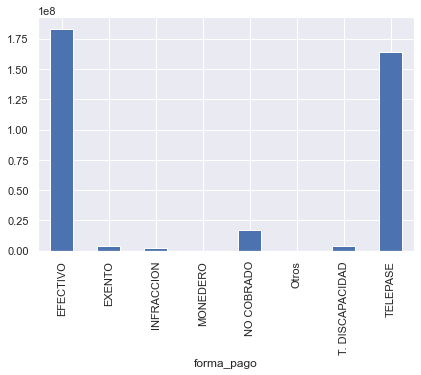

In [15]:
dataset.groupby([dataset.forma_pago])['cantidad_pasos'].sum().round(2).plot(kind='bar')

Efectivo y Telepase practicamente totalizan los pagos

### Peajes por tipo de vehículo

In [16]:
dataset.groupby([dataset.tipo_vehiculo, dataset.periodo])['cantidad_pasos'].sum()

tipo_vehiculo  periodo
Liviano        2017       113674277
               2018       112371359
               2019       112119160
Pesado         2017        11159213
               2018        10722333
               2019        14591365
Name: cantidad_pasos, dtype: int64

## Estación Illia

In [17]:
mask_Illia = dataset.estacion=='Illia'
dataset_Illia= dataset[mask_Illia]

### Pantallazo al período completo

Vamos a comenzar por descripción básica. Hacemos una vista cenital de la ventana de tiempo completa, **resampleado en días**, del total de peajes de la estación Illia.

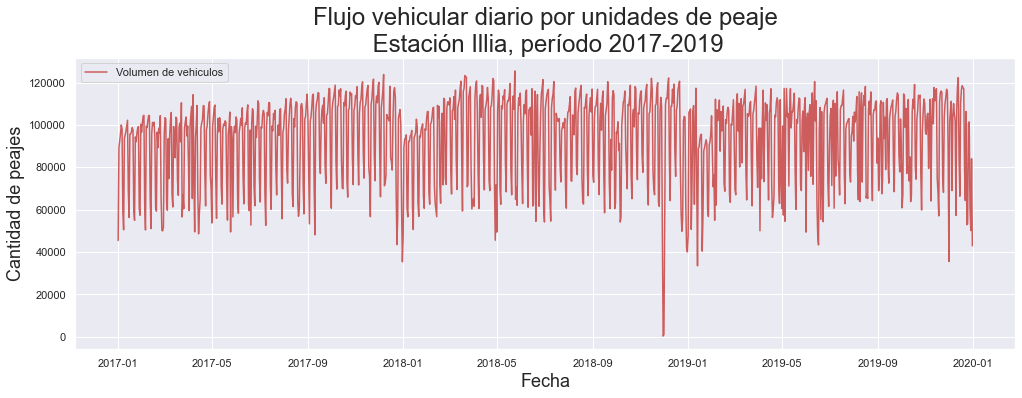

In [18]:
diario_Illia = dataset_Illia.resample('D', on = 'fecha').sum()

plt.figure(figsize = (15,5))
plt.plot(diario_Illia.index, diario_Illia.cantidad_pasos, label = 'Volumen de vehiculos', color='indianred')
plt.title('Flujo vehicular diario por unidades de peaje\n Estación Illia, período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend()
plt.show()

La estacionalidad diaria nos dificulta la visualización. Lo **resampleo a semanal**.

<Figure size 432x288 with 0 Axes>

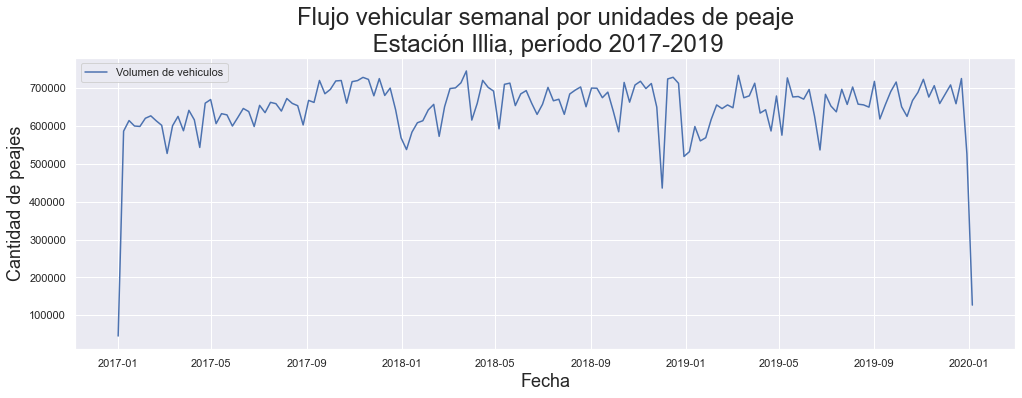

In [19]:
semanal_Illia = dataset_Illia.resample('W', on = 'fecha').sum()
plt.figure(facecolor='#d8dcd6')
plt.figure(figsize = (15,5))
plt.plot(semanal_Illia.index, semanal_Illia.cantidad_pasos, label = 'Volumen de vehiculos')
plt.title('Flujo vehicular semanal por unidades de peaje\n Estación Illia, período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
#plt.ylim(400000,800000)
plt.legend()
plt.show()

La primera y última semana contienen uno (Domingo), y dos días (Lunes y Martes). A eso se debe fundamentalmente que sean de tan bajo 'cantidad_pases'. 

Como es de esperar, se observa una caída brusca en el flujo vehícular en el início de cada año. Luego lo analizaremos más detenidamente en el estudio de estacionalidad. Por otra parte, el año 2017 parece mostrar un crecimiento sostenido durante todo el año, mientras que 2018 y 2019 parecen con tendencia estacionaria en la media, pero con valores mucho más volátiles.

Para terminar esta parte, vamos a mirar con granularidad mensual.

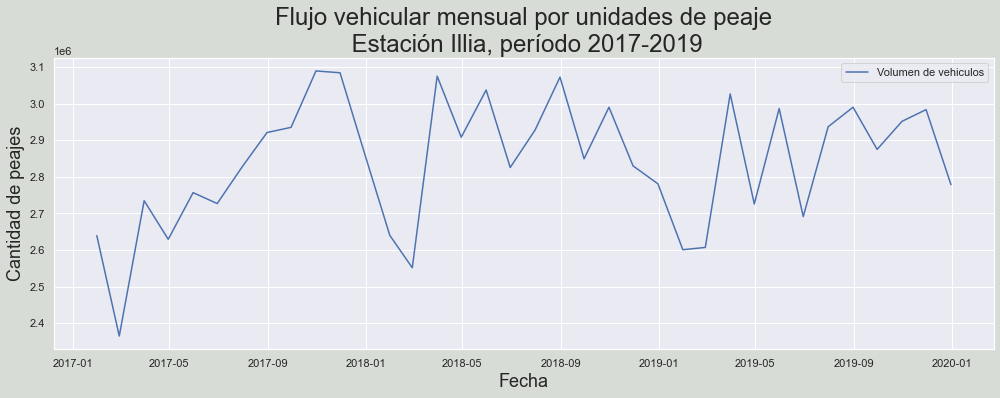

In [20]:
mensual_Illia = dataset_Illia.resample('M', on = 'fecha').sum()
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
plt.plot(mensual_Illia.index, mensual_Illia.cantidad_pasos, label = 'Volumen de vehiculos')
plt.title('Flujo vehicular mensual por unidades de peaje\n Estación Illia, período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
#plt.ylim(400000,800000)
plt.legend()
plt.show()

Acá apreciamos lo que mencionamos del año 2017. Pero 2018 y 2019 parecen tener una media diferente. De hecho, 2018 parece tener tendencia negativa, mientras que en 20119 sería estacionaria. Luego lo miraremos desestacionalizado.

### Distribución mensual del flujo vehícular

Vamos a agrupar por mes para compararlos

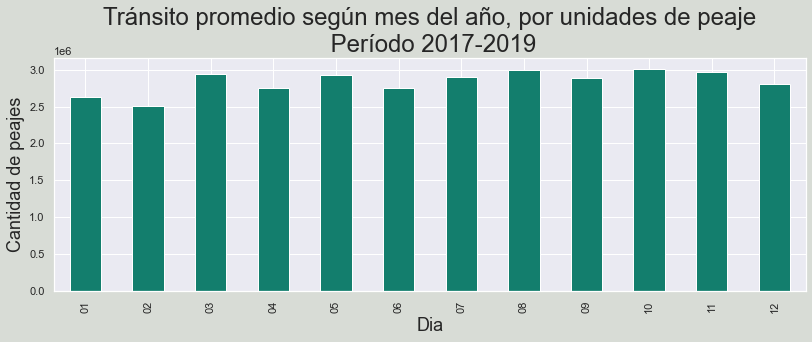

In [21]:
#creo una variable texto con el número del mes, dentro de la serie resampleada por mes.
#Tengo que ver como pasarla al nombre del mes (tip=month_name)
mensual_Illia['Mes']= mensual_Illia.index.strftime('%m')

#Agrupo x mes, y obtengo el promedio de peajes correspondiente a cada uno 
mensual_Illia_agrupado= mensual_Illia.groupby(['Mes'])['cantidad_pasos'].mean().round(0)

#Grafico con barras. Tengo que modificar la leyenda de la escala y
plt.figure(figsize = (12,4), facecolor='#d8dcd6')
mensual_Illia_agrupado.plot.bar(color=['#137e6d'], edgecolor='w')
plt.title('Tránsito promedio según mes del año, por unidades de peaje\n Período 2017-2019', fontsize=24)
plt.xlabel('Dia', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
#plt.ylim(400000,800000)
#plt.legend()
plt.show()

A diferencia de lo que pensabamos, el flujo vehicular no se desploma en verano ni en vacaciones de invierno. La diferencia entre máximo y mínimo es de sólo 1/6 (500.000 sobre 3.000.000). 

¿Hay estacionalidad anual? No podemos inferirlo de este gráfico. Debemos graficar los meses desagregados por año, y compararlos. Esto lo analizaremos en el estudio de autocorrelación.


### Distribución semanal del flujo vehicular

¿Que días registran el mayor flujo vehicular?, ¿cuál es el día de menor tránsito? Vamos a agrupar por día para investigar como se distribuye el flujo vehicular a lo largo de la semana.

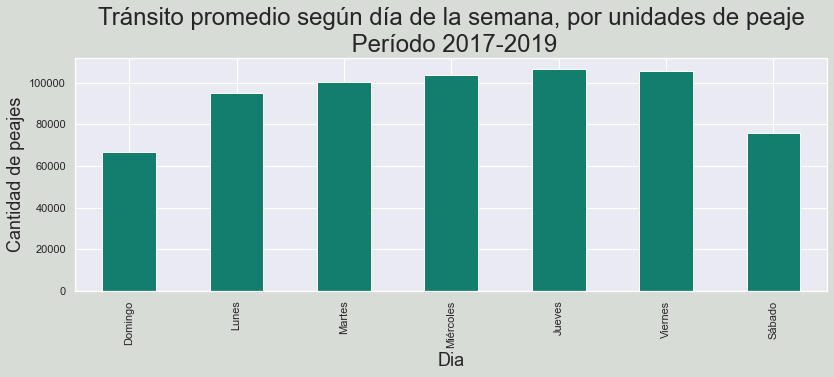

In [22]:
#import calendar
#calendar.setfirstweekday(calendar.MONDAY)

#creo una variable texto con el nombre del día, dentro de la serie resampleada por día.
#Tengo que ver como pasarla al castellano
diario_Illia ['Día'] = diario_Illia.index.day_name(locale='Spanish')

#Agrupo x dia, y obtengo el promedio de peajes correspondiente a cada uno 
diario_Illia_agrupado= diario_Illia.groupby(['Día'], sort=False)['cantidad_pasos'].mean().round(0)
#print(diario_Illia_agrupado)

#Grafico con barras. Tengo que modificar la leyenda de la escala y
plt.figure(figsize = (12,4), facecolor='#d8dcd6')
diario_Illia_agrupado.plot.bar(color=['#137e6d'], edgecolor='w')
plt.title('Tránsito promedio según día de la semana, por unidades de peaje\n Período 2017-2019', fontsize=24)
plt.xlabel('Dia', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
#plt.ylim(400000,800000)
#plt.legend()
plt.show()

El tránsito crece constante desde el Lunes hasta el Jueves, el pico, con 106563 peajes diarios en promedio, y luego inicia el descenso hasta el Domingo, día en que encontramos (previsiblemente) el mínimo flujo vehicular semanal, un 37% inferior respecto del máximo del Jueves.

### Distribución horaria del flujo vehicular

Nos preguntamos algo similar a lo anterior. ¿Cómo se distribuye el flujo vehicular a lo largo del día?, ¿hay picos en horarios que podríamos considerar de "ida y regreso del trabajo"?, ¿qué diferencia se registra en volúmen de tránsito entre las horas de menor y mayor congestión?

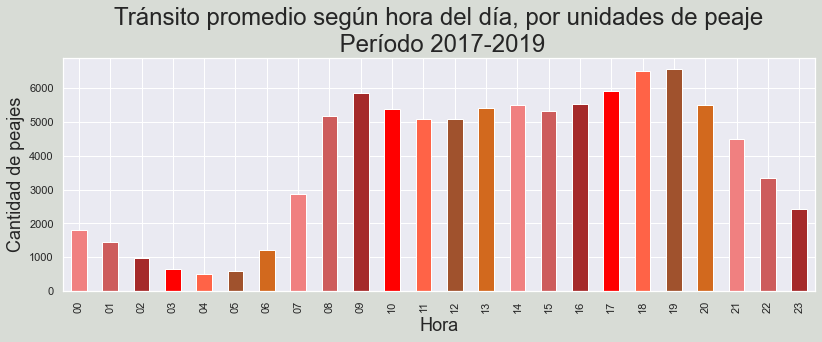

<Figure size 432x288 with 0 Axes>

In [23]:
horaria_Illia = dataset_Illia.resample('H', on = 'fecha').sum()
horaria_Illia ['Hora'] = horaria_Illia.index.strftime('%H')
horaria_Illia_agrupado = horaria_Illia.groupby(['Hora'], sort=False)['cantidad_pasos'].mean()
#print(horaria_Illia_agrupado)

#Grafico histograma
plt.figure(figsize = (12,4), facecolor='#d8dcd6')
horaria_Illia_agrupado.plot.bar(color=['lightcoral', 'indianred', 'brown', 
                                       'red', 'tomato', 'sienna', 'chocolate'], edgecolor='w')
plt.title('Tránsito promedio según hora del día, por unidades de peaje\n Período 2017-2019',
          fontsize=24)
plt.xlabel('Hora', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18) 
plt.figure().patch.set_facecolor('xkcd:mint green')
#plt.ylim(400000,800000)
#plt.legend()
plt.show()

Como esperabamos, hay picos consistentes con horas de inicio y fin de jornada laboral, en torno a las 9hs y a las 19hs, respectivamente. Sin embargo, entre ellas, no hay un descenso marcado en el flujo vehicular. El tramo horario que va de las 8hs a las 20hs fluctúa en una banda que no perfora el 25% de diferencia respecto del máximo, ayudando a formar una suerte de "Golden Gate", semejante a una distribución bimodal. Por otra parte, la franja horaria de las 3hs a 5hs es la de menor cantidad de peajes. A "grosso modo", el horario de las 4hs representa poco menos del 8% del flujo registrado a las 19hs. 

### Análisis por sentido de circulación

**Vamos a hacer el mismo análisis, pero desagregando sentido centro y provincia. Surgen muchos interrogantes: ¿se iguala diariamente el flujo vehicular entre ambos sentidos?, ¿cómo evoluciona en el tiempo esa relación?, ¿cambia la distribución horaria del flujo vehicular según el sentido de circulación?.** 

Empecemos por mirar el flujo neto de circulación diario por sentido

In [24]:
#máscara x sentido
Illia_Centro = dataset_Illia[(dataset_Illia['sentido']=='Centro')]
Illia_Provincia = dataset_Illia[(dataset_Illia['sentido']=='Provincia')]

#Resampleamos a día
diario_Illia_Centro = Illia_Centro.resample('D', on = 'fecha').sum()
diario_Illia_Provincia = Illia_Provincia.resample('D', on = 'fecha').sum()

<Figure size 432x288 with 0 Axes>

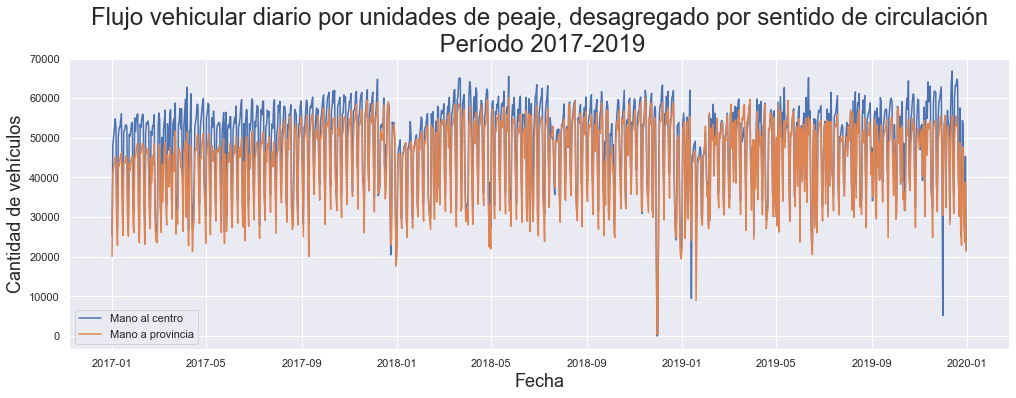

In [25]:
plt.figure(facecolor='#d8dcd6')
plt.figure(figsize = (15,5))
plt.plot(diario_Illia_Centro.index, diario_Illia_Centro.cantidad_pasos, label = 'Mano al centro')
plt.plot(diario_Illia_Provincia.index, diario_Illia_Provincia.cantidad_pasos, label = 'Mano a provincia')
plt.title('Flujo vehicular diario por unidades de peaje, desagregado por sentido de circulación\n Período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de vehículos', fontsize=18)
# plt.xlim(datetime.date(1990,1,1), datetime.date(2018,1,1))
#plt.ylim(20000,70000)
plt.legend()
plt.show()

Entonces, ¿se iguala el volumen de vehículos que recorren la autopista diariamente en sentido centro y provincia? No parece ser el caso, sobre todo el primer año de análisis. Siempre (o casi) el flujo vehicular mano al centro es superior al flujo mano a provincia. Vamos a representar gráficamente la diferencia neta entre ambos sentidos de circulación, para observar más nítidamente.

In [26]:
sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

<Figure size 432x288 with 0 Axes>

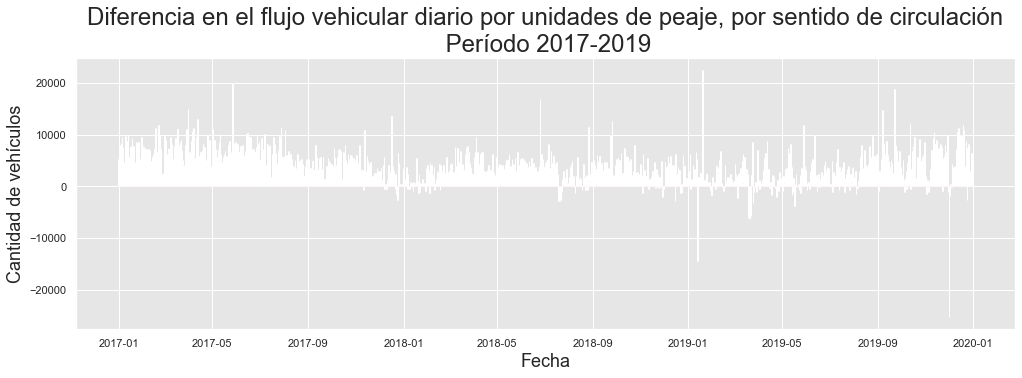

In [27]:
diferencia_diaria_Illia = diario_Illia_Centro-diario_Illia_Provincia

plt.figure(facecolor='#d8dcd6')
plt.figure(figsize = (15,5))
plt.bar(diferencia_diaria_Illia.index, diferencia_diaria_Illia.cantidad_pasos,color='red')  
plt.title('Diferencia en el flujo vehicular diario por unidades de peaje, por sentido de circulación\n Período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de vehículos', fontsize=18)
#plt.ylim(-10000,20000)
#plt.legend()
plt.show()

Esta es la diferencia neta entre mano centro y provincia. No encontramos una forma mejor de representarlo. Comprobamos lo anterior. El barplot graficado es el resultado de la resta (mano centro) - (mano provincia). Pero esa brecha no parece estable, lineal, sino más bien una parábola. Vamos a resamplear a mensual.

In [28]:
#Resampleamos a mes
mensual_Centro = diario_Illia_Centro.resample('M').sum()
mensual_Provincia = diario_Illia_Provincia.resample('M').sum()

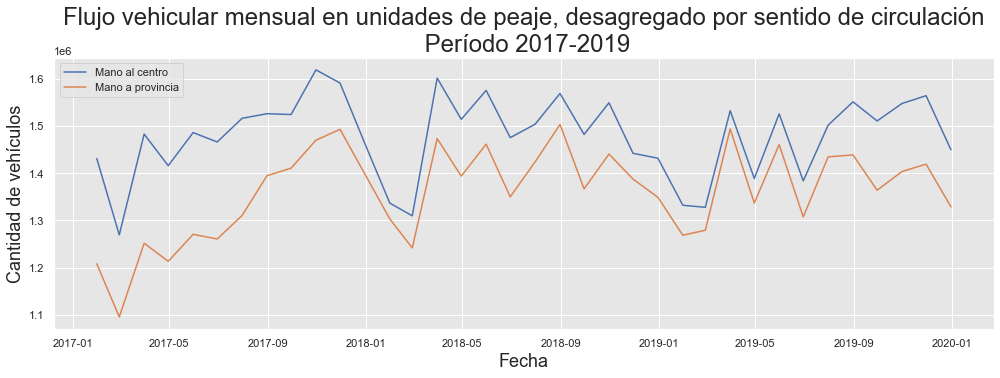

In [29]:
plt.figure(figsize = (15,5))
plt.plot(mensual_Centro.index, mensual_Centro.cantidad_pasos, label = 'Mano al centro')
plt.plot(mensual_Provincia.index, mensual_Provincia.cantidad_pasos, label = 'Mano a provincia')
plt.title('Flujo vehicular mensual en unidades de peaje, desagregado por sentido de circulación\n Período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de vehículos', fontsize=18)
# plt.xlim(datetime.date(1990,1,1), datetime.date(2018,1,1))
#plt.ylim(20000,70000)
plt.legend()
plt.show()

Vemos ambas series, resampleadas a mensual. En 2017 parece ir cerrandose conforme avanza el año. En 2018 se mantiene estable en los valores alcanzados el año anterior, y en 2019 parece cerrarse aún más en el primer semestre, pero luego vuelve a hacerse divergente. Si tuviese que intuir el motivo de esta brecha, diría que tiene que ver con el valor del tiempo (en términos microeconómicos, la "utilidad del tiempo"), y en cómo difiere éste. 

El tiempo es siempre el mismo, pero la valoración que hacemos de éste cambia. Por ejemplo, viajar en autopista al trabajo nos permite descansar más tiempo y acortar la duración del viaje. Este tiempo extra de ocio en la mañana es algo por lo que podríamos estar dispuestos a pagar, siempre dependiendo el costo del peaje. Pero no a la tarde. Ya con el día iniciado, el valor del tiempo es diferente, quizás menor, y no justifiquemos el costo del peaje por ahorrarnos unos minutos. 
Pero esta no es la única explicación. También es posible que el retorno a casa incluya realizar las compras en el camino, o realizar otras actividades, para las cuales no sea necesario tomar la autopista, o no lo justifique.

Creo que lo anterior justifica que realicemos un análisis de sensibilidad al cambio de precio del peaje (información que deberemos obtener).La hipótesis: "el viaje al trabajo" es un bien necesario, menos elástico, mientras que la vuelta (siempre asumiendo que en Capital se trabaja mientras que en sentido a provincia se vive), es un bien normal o de lujo. Usar un camino alternativo a la autopista insume naturalmente más tiempo. Pero ese tiempo es más valioso a la mañana, que para la hora del regreso. 

Vamos a graficar la diferencia neta mensual, y tratar de aproximar la brecha con una media movil, para ver si confirmamos el movimiento descrito en el primer párrafo.

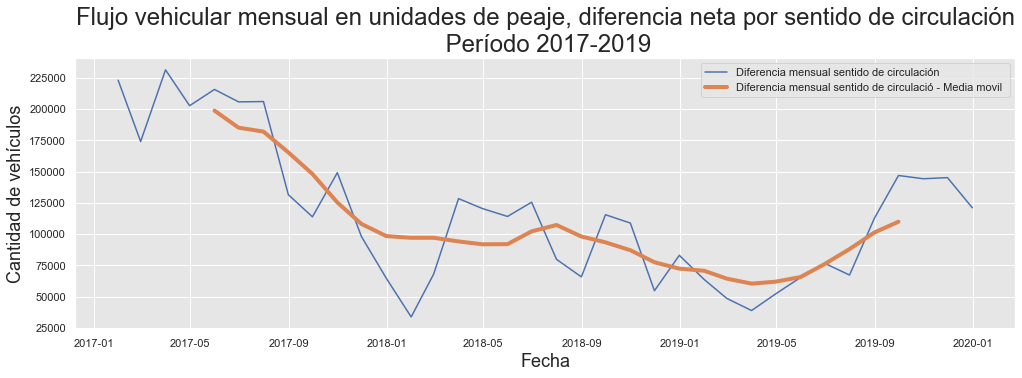

In [30]:
diferencia_mensual = mensual_Centro-mensual_Provincia

ventana = 8
diferencia_mensual_promedio = diferencia_mensual.cantidad_pasos.rolling(window=ventana, center = True).mean()
plt.figure(figsize = (15,5))
plt.plot(diferencia_mensual.index, diferencia_mensual.cantidad_pasos, label = 'Diferencia mensual sentido de circulación')
plt.plot(diferencia_mensual_promedio, lw = 4, label = 'Diferencia mensual sentido de circulació - Media movil ')
plt.title('Flujo vehicular mensual en unidades de peaje, diferencia neta por sentido de circulación\n Período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de vehículos', fontsize=18)
plt.legend()
plt.show()

Se observa la parábola. Vamos a tener que buscar datos externos para entender este movimiento. 

### Formas de pago

El trabajo es con medio de pago en efectivo, sin embargo, vamos a analizar a todos ellos. Primero, analizemos su distribución.

In [31]:
dataset_Illia.groupby([dataset_Illia.forma_pago])['cantidad_pasos'].sum()#.plot(kind='pie')

forma_pago
EFECTIVO           47865581
EXENTO               642523
INFRACCION           340809
MONEDERO                 16
NO COBRADO          2328340
T. DISCAPACIDAD      512442
TELEPASE           50526078
Name: cantidad_pasos, dtype: int64

Como en el analisis del total de estaciones, prevalecen los pagos en efectivo y Telepase. Vamos a mirarlo desagregado por sentido

In [32]:
dataset_Illia.groupby([dataset_Illia.forma_pago, dataset_Illia.sentido])['cantidad_pasos'].sum()#.sort_values()#.plot(kind='pie')

forma_pago       sentido  
EFECTIVO         Centro       24707366
                 Provincia    23158215
EXENTO           Centro         342423
                 Provincia      300100
INFRACCION       Centro         185012
                 Provincia      155797
MONEDERO         Centro              8
                 Provincia           8
NO COBRADO       Centro        1279681
                 Provincia     1048659
T. DISCAPACIDAD  Centro         264638
                 Provincia      247804
TELEPASE         Centro       26426589
                 Provincia    24099489
Name: cantidad_pasos, dtype: int64

La cantidad de **peajes mano al centro es superior a los de mano a provincia, para todos los medios de pago** (incluso los que no representan erogación). 

Analizemos la evolución de los pagos en efectivo y Telepase, los más significativos, para el periodo de estudio. Lo resampleo a semanal para favorecer visualización

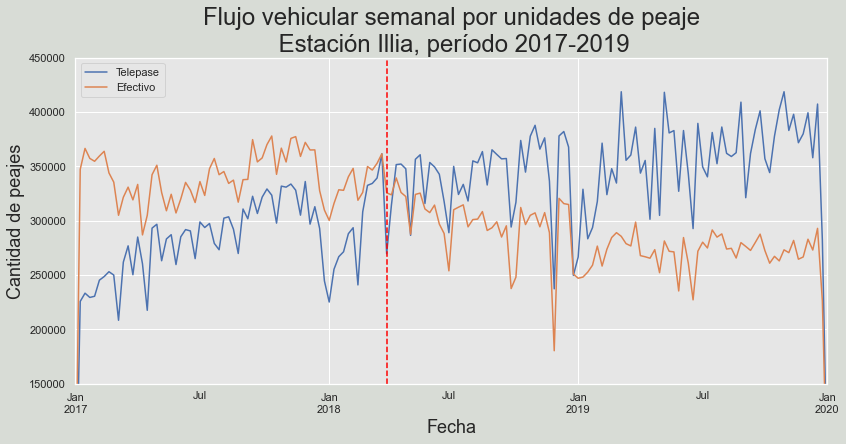

In [33]:
plt.figure(facecolor='#d8dcd6')
dataset_TLPS = dataset_Illia[(dataset_Illia['forma_pago']== 'TELEPASE')].resample('W', on='fecha')['cantidad_pasos'].sum().plot(figsize = (12,6))
dataset_EFTO = dataset_Illia[(dataset_Illia['forma_pago']== 'EFECTIVO')].resample('W', on='fecha')['cantidad_pasos'].sum().plot(figsize = (12,6))
plt.title('Flujo vehicular semanal por unidades de peaje\n Estación Illia, período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.ylim(150000,450000)
threshold_date = pd.to_datetime('2018-03-29')
plt.axvline(threshold_date, color='red', linestyle='--', label='train test split')
plt.legend(['Telepase','Efectivo'])
plt.show()

De cara el proyecto, observamos que **el pago en EFECTIVO decrece desde abril-mayo de 2018**, cerca del momento en que se intersecta con el pago mediante TELEPASE. Antes de eso parece estable. En relación al **TELEPASE, se mantuvo creciente durante el total de la ventana de tiempo**. ¿Razones? El **29/03/2018 se registró un incremento cercano al 14% en el valor de los peajes**. Y el pago mediante TELEPASE ofrece un 15% de descuento sobre el valor en efectivo. Es posible que el aumento de precios acelerara la conversión en el medio de pago.

Grafico nuevamente la serie en efectivo, con un threshold en la fecha del aumento en el valor del peaje.

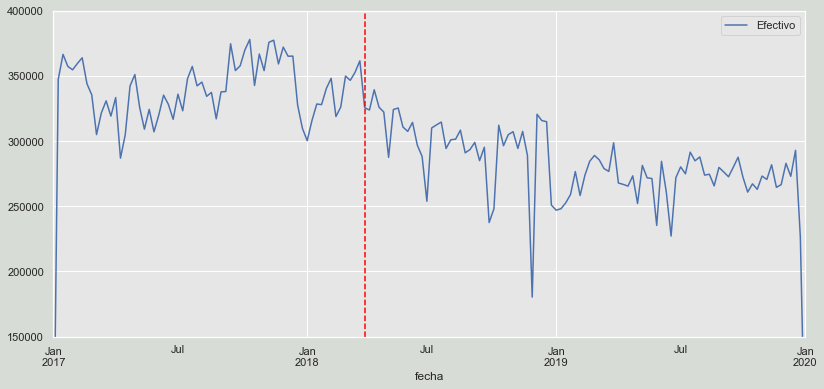

In [34]:
plt.figure(facecolor='#d8dcd6')
dataset_Illia[(dataset_Illia['forma_pago']== 'EFECTIVO')].resample('W', on='fecha')['cantidad_pasos'].sum().plot(figsize=(12,6))
plt.legend(['Efectivo'])
threshold_date = pd.to_datetime('2018-03-29')
plt.axvline(threshold_date, color='red', linestyle='--', label='train test split')
plt.ylim(150000,400000)
plt.show()

Parece obvio que hay un quiebre en la tendencia. Lo revisaremos más adelante. 

### Tipo de vehículo

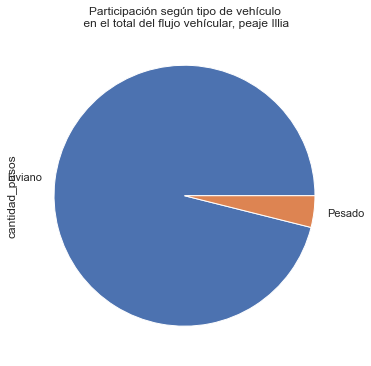

In [35]:
ax= dataset_Illia.groupby([dataset_Illia.tipo_vehiculo])['cantidad_pasos'].sum().plot(kind='pie', figsize=(12,6), title= 'Participación según tipo de vehículo\n en el total del flujo vehícular, peaje Illia')

# Preprocesamiento

Realizaremos dos tareas:
- Verificar la existencia de datos faltantes (fecha o cantidad de pasos)
- Verificar outliers

En caso de existir alguno de los anteriores, vamos a usar la función interpolate() o un filtro Hampel. Vale aclarar que no todos los modelos precisan del depurado. Prophet, por ejemplo, trabaja bien con datos faltantes y outliers. Asimismo, los modelos ARIMA y SARIMA requieren de conocer el orden de diferenciación para volver estacionaria la serie, tarea que formaría parte del preprocesamiento. Volveremos a esto cuando trabajemos cada punto. 

Vamos a realizar el filtrado para pago en efectivo y quitar columnas que ya no utilizaremos

In [36]:
dataset_Illia = dataset_Illia[(dataset_Illia['forma_pago']=='EFECTIVO')]

#dataset.drop(columns = ['periodo','hora_inicio', 'hora_fin'], inplace = True)
#dataset_Illia.reset_index()

## Datos faltantes

Aquí veremos si algún valor es nulo (Nan o "_")

In [37]:
dataset_Illia.isnull().sum()

periodo           0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
fecha             0
dtype: int64

In [38]:
dataset_Illia.head()

periodo  hora_inicio  hora_fin      dia estacion sentido tipo_vehiculo  \
1750     2017            0         1  Domingo    Illia  Centro       Liviano   
1755     2017            1         2  Domingo    Illia  Centro       Liviano   
1757     2017            1         2  Domingo    Illia  Centro       Liviano   
1761     2017            1         2  Domingo    Illia  Centro        Pesado   
1764     2017            2         3  Domingo    Illia  Centro       Liviano   

     forma_pago  cantidad_pasos               fecha  
1750   EFECTIVO               1 2017-01-01 01:00:00  
1755   EFECTIVO              10 2017-01-01 02:00:00  
1757   EFECTIVO             783 2017-01-01 02:00:00  
1761   EFECTIVO               3 2017-01-01 02:00:00  
1764   EFECTIVO              14 2017-01-01 03:00:00

No hay valores nulos o faltantes. Nos queda ver si faltan días. Vamos a definir una variable que registre la distancia entre registros. Si hubiese algún valor >1, significaría que falta alguno.

In [39]:
dataset_Illia_diario = dataset_Illia.resample('D', on='fecha').sum()

dataset_Illia_diario['fecha_numeros']=dataset_Illia_diario.index.map(datetime.datetime.toordinal)

In [40]:
dataset_Illia_diario['date_check'] = dataset_Illia_diario.fecha_numeros.diff()
dataset_Illia_diario.date_check.value_counts()

1.0    1094
Name: date_check, dtype: int64

**No faltan registros diarios**. Vamos a mirar outliers. 

## Outliers

No todos los modelos son sensibles a outliers. Prophet, por ejemplo, no requiere de un preprocesamiento. Sin embargo, si lo precisamos para ARIMA y para el benchmark. 

Vamos a graficar para identificar valores atípicos 

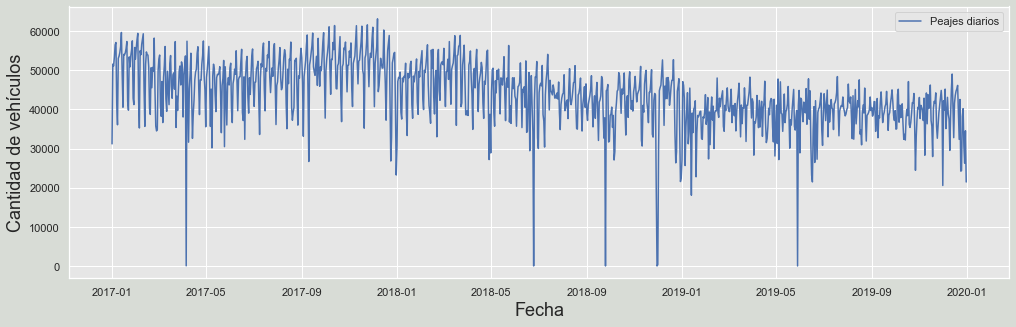

In [41]:
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
plt.plot(dataset_Illia_diario.index, dataset_Illia_diario.cantidad_pasos, label = 'Peajes diarios')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de vehículos', fontsize=18)
#plt.xlim(datetime.date(2017,4,1), datetime.date(2017,4,9))
#plt.ylim(20000,70000)
plt.legend()
plt.show()

Observamos valores cercanos a cero. Hacemos una máscara para detectarlos.

In [42]:
mask_0= dataset_Illia_diario[(dataset_Illia_diario['cantidad_pasos']<=10000)]
mask_0

periodo  hora_inicio  hora_fin  cantidad_pasos  fecha_numeros  \
fecha                                                                       
2017-04-06     6051            0         3              40         736425   
2018-06-25        0            0         0               0         736870   
2018-09-25        0            0         0               0         736962   
2018-11-30        0            0         0               0         737028   
2018-12-01    22198          249        92             350         737029   
2019-05-29        0            0         0               0         737208   

            date_check  
fecha                   
2017-04-06         1.0  
2018-06-25         1.0  
2018-09-25         1.0  
2018-11-30         1.0  
2018-12-01         1.0  
2019-05-29         1.0

Tenemos huelgas de actividad, así como eventos asociados a la cumbre del G20. Acá podemos usar un filtro de Hampel, o Interpolate, o algo más. El punto no sería sólo sacar valores "extremos", sino aquellos que, sin ser aberrantes, respondan a comportamientos fuera de un límite lógico.

Voy a utilizar un filtro Hampel. Le doy una ventana lo suficientemente grande (10 días), y hasta 4 desvíos estandard, para asegurar de quitar valores que realmente resulten anómalos.

In [43]:
#import warnings
def hampel_filter_forloop(input_series, window_size, n_sigmas=4):
    
    n = len(input_series)
    new_series = input_series.copy()
    k = 1.4826 # scale factor for Gaussian distribution
    
    indices = []
    
    # possibly use np.nanmedian 
    for i in range((window_size),(n - window_size)):
        x0 = np.median(input_series[(i - window_size):(i + window_size)])
        S0 = k * np.median(np.abs(input_series[(i - window_size):(i + window_size)] - x0))
        if (np.abs(input_series[i] - x0) > n_sigmas * S0):
            new_series[i] = x0
            indices.append(i)
    
    return new_series, indices

In [44]:
res, detected_outliers = hampel_filter_forloop(dataset_Illia_diario.cantidad_pasos, 10)

In [45]:
#creamos nueva variable con los peajes tratados por outliers
dataset_Illia_diario['cantidad_peajes'] = res

In [46]:
dataset_Illia_diario.head()

periodo  hora_inicio  hora_fin  cantidad_pasos  fecha_numeros  \
fecha                                                                       
2017-01-01   465927         3033      2976           31183         736330   
2017-01-02   637372         3709      3713           51568         736331   
2017-01-03   619219         3602      3573           51093         736332   
2017-01-04   647457         3828      3909           53332         736333   
2017-01-05   641406         3790      3820           56486         736334   

            date_check  cantidad_peajes  
fecha                                    
2017-01-01         NaN            31183  
2017-01-02         1.0            51568  
2017-01-03         1.0            51093  
2017-01-04         1.0            53332  
2017-01-05         1.0            56486

Vamos a graficar ambas series (original, y sin outliers), para compararlas

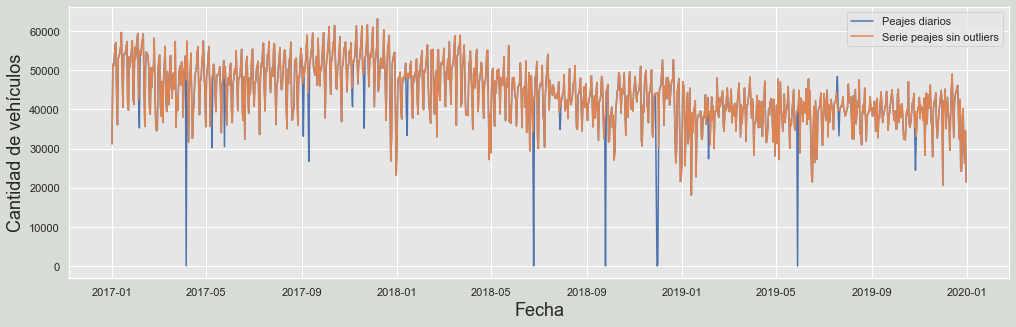

In [47]:
plt.figure(figsize = (15,5), facecolor='#d8dcd6')
plt.plot(dataset_Illia_diario.index, dataset_Illia_diario.cantidad_pasos, label = 'Peajes diarios')
plt.plot(dataset_Illia_diario.index, dataset_Illia_diario.cantidad_peajes, label = 'Serie peajes sin outliers')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de vehículos', fontsize=18)
#plt.xlim(datetime.date(2017,4,1), datetime.date(2017,4,9))
#plt.ylim(20000,70000)
plt.legend()
plt.show()

Vemos que el filtro elimina los outliers detectados anteriormente. Adicionalmente, quita otros trece valores que no pasan el filtro.

Hay **otras acciones para el preprocesamiento** (como la normalización de la media y la varianza), **pero estas dependen que tratemos con una serie no estacionaria**. Volveremos a ello en el punto 5 inciso 4.

# Proyecto: cuestiones metodológicas

Es clara la **evidencia de estacionalidad múltiple** en el comportamiento de la serie día a día, delineando ciclos semanales (entre días laborables y no laborables), así cómo anuales (temporada estival), e incluso intra-diarios (horarios de ingreso/egreso laboral), fenómeno **que no todos los modelos logran incorporar**. Podríamos, por ejemplo, incrementar granularidad a mensual, de modo de sólo tener por delante una clase de estacionalidad, pero el trade-off significa sacrificar cantidad de datos y probablemente tener underfitting. 

Adicionalmente, luego de observar la serie con pago en efectivo, también **es claro el quiebre de tendencia**, lo cuál, para un correcto tratamiento del problema, implicaría trabajar con datos desde fin de marzo del 2018, agravando el problema antes mencionado de la escasez de datos.

Hemos trabajado con varios resampleos, llevando esto a distintos inconvenientes. Por ejemplo, el modelo SARIMA presenta grandes dificultades de procesamiento con frecuenciaa diaria, y mostrandose muy impreciso cuando la misma es mensual. Por otra parte, no acepta estacionalidad compleja, condición que sí satisface Prophet. 

El punto aquí es: **¿cuál sería el requerimiento del usuario del informe?**, y también, **¿que hito podemos alcanzar con nuestro conocimiento limitado del problema, de los métodos, y de la limitada cantidad de datos?** Es evidente que debemos "sortear" un tipo de estacionalidad, pero sin sacrificar demasiados datos. Creemos, pensando en objetivos modestos, que *sería de mayor utilidad conocer (estimar) el dato semanal/mensual de peajes y su tendencia, antes que conocer el flujo vehícular de una fecha u hora específica.*

En función al objetivo anterior, conduciremos el análisis *trabajando con resampleo semanal, aún cuando entendemos que no estamos trabajando de la forma óptima*.

Dejamos para el proyecto 4 la posibilidad de ampliar la serie con datos de otros años, y la prueba con redes neuronales (RNN y LSTM), y de otros modelos para multiple estacionalidad, como por ejemplo TBATS (Blaconá & Andreozzi, 2013), así como de pruebas multivariadas, con el uso de modelos de ensamble, así como con SARIMA.

# **Tendencia, estacionalidad y ruido**

Iniciamos con un análisis de rolling window sobre la media y el desvío estandar. Luego descompondremos la serie con la función de statsmodels.

In [48]:
#Resampleamos a semanal
dataset_Illia_W = dataset_Illia_diario.resample ('W').sum()
#Dropeamos columnas
dataset_Illia_W = dataset_Illia_W.drop(columns=['periodo', 'hora_inicio', 'hora_fin', 
                    'cantidad_pasos', 'fecha_numeros',  'date_check',])
dataset_Illia_W.head()

cantidad_peajes
fecha                      
2017-01-01            31183
2017-01-08           347212
2017-01-15           366413
2017-01-22           357215
2017-01-29           354581

## Análisis de la serie con rolling window

Aún no hablamos de modelos. Muchos de ellos requieren series estacionarias para poder trabajar eficientemente, es decir, media, varianza, y covarianza constante. Los modelos AR(), MA, y ARMA, son algunos de ellos. Con series no estacionarias (con tendencia), el ARIMA funciona mejor, ya que incorpora dentro de sus parámetros la posibilidad de indicar el grado de diferenciación necesario para tornar estacionaria la serie con tendencia. Pero no acepta series con estacionalidad. Aquí es dónde entra el SARIMA. Parte de los análisis que siguen tienen la intención de demostrar que se posee una acabada comprensión de los temas tratados, pero, adicionalmente, que se entiende que ciertos tipos de transformaciones y análisis sólo tienen sentido en presencia de las barreras antes detalladas. Es por ello que iniciamos esta sección con una sómera revisión de la naturaleza de la media y el desvío estandar de la serie, en la búsqueda de establecer con claridad si ésta es o no estacionaria. Luego de ello, realizaremos las transformaciones necesarias para tomar de ellas los datos requeridos para ciertos modelos. Vale aclarar, al respecto, que Prophet no precisa de este desarrollo.  

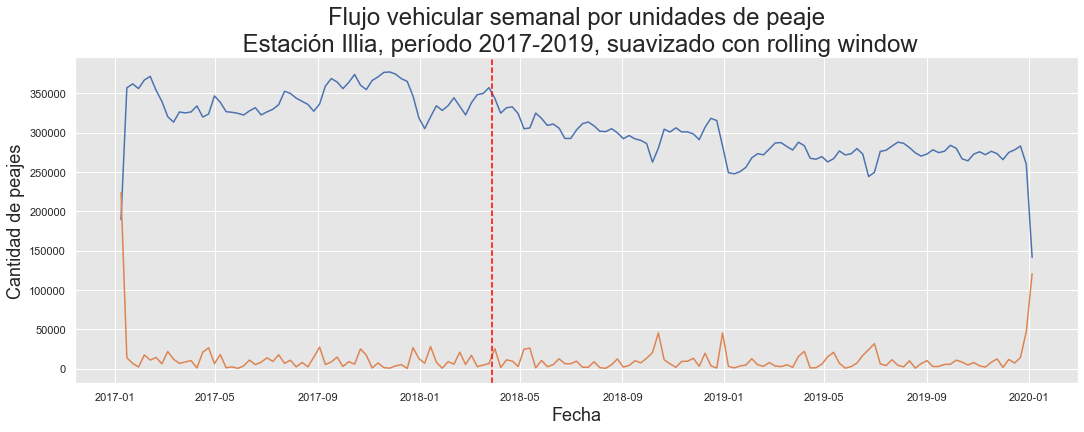

In [49]:
plt.figure(figsize=(16,6))
plt.plot(dataset_Illia_W.cantidad_peajes.rolling(window=2,center=False).mean(),label='Rolling Mean');
plt.plot(dataset_Illia_W.cantidad_peajes.rolling(window=2,center=False).std(),label='Rolling sd');
plt.title('Flujo vehicular semanal por unidades de peaje\n Estación Illia, período 2017-2019, suavizado con rolling window', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
threshold_date = pd.to_datetime('2018-03-29')
plt.axvline(threshold_date, color='red', linestyle='--', label='train test split')
plt.show()

Cómo ya observamos en el punto 2.4.6., la serie parece mostrar una clara tendencia descendente, sobre todo a partir de abril 2018, pero no es tan claro antes de esa fecha. El desvío estandard parece haberse mantenido estable. A priori, ¿estamos hablando de una serie no estacionaria? Vamos a produndizar en este análisis.

## ¿Es estacionaria la serie?

Hay varias formas de responder a esta pregunta. Intuitívamente, vasta con mirar si la media, varianza, y covarianza (o alguna de ellas), se mantienen estables en todo el período. Para nuestro caso, y en diversas oportunidades, ya observamos que no parece ser el caso, desde el momento en que la serie presenta tendencia y estacionalidad (ver gráfico precedente, y el de media móvil en apartado 6.1., , por ejemplo). 
De entre los métodos formales, el *Augmented Dickey–Fuller test* y el Kwiatkowski-Phillips-Schmidt-Shin test sirven para verificar, por vías distintas, si la serie no posee tendencia, y con ello, si la variación en Yt se explica sólo por el componente de ruido. Sin embargo, como veremos, el resultado puede ser contradictorio. 

Vamos a probar el ADF test con un 95% de significancia. La Ho es que la serie presenta raíz unitaria, y con ello, que no es estacionaria. Si el p-value da por dabajo de 0,05, entonces rechazamos la hipótesis nula, y aceptamos que la serie es estacionaria. En cuanto a transformación de los datos, el resampleo a mensual ayuda a quitar ruido, por lo que de momento no realizaremos preprocesamiento.

In [50]:
#AUgmented Dicki-Fuller test
from statsmodels.tsa.stattools import adfuller
adf = adfuller(dataset_Illia_W['cantidad_peajes'], regression= 'ct')
print("p-value: {}".format(float(adf[1])))

p-value: 1.0251085491632196e-18


Para el ADF test rechazamos la H0, por lo tanto, aceptamos la HA de que la serie es estacionaria. Pero esto parece contrafáctico. Veamos ahora el kpss test. Aquí, Ho e HA se invierten. Si el p-value < 0,05, entonces rechazamos la Ho, y la serie es no-estacionaria.

In [51]:
from statsmodels.tsa.stattools import kpss
kpss = kpss(dataset_Illia_W['cantidad_peajes'], regression= 'ct')
print("p-value: {}".format(float(kpss[1])))

p-value: 0.03870009716037365


C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\statsmodels\tsa\stattools.py:1843: FutureWarning: The behavior of using nlags=None will change in release 0.13.Currently nlags=None is the same as nlags="legacy", and so a sample-size lag length is used. After the next release, the default will change to be the same as nlags="auto" which uses an automatic lag length selection method. To silence this warning, either use "auto" or "legacy"
  warnings.warn(msg, FutureWarning)


Y aquello es lo que sucede. Según el kpss test, la serie es no estacionaria. ¿A que se debe? Posiblemente, a que la serie tiene quiebre de tendencia (lo que observamos con el aumento de marzo del 2018). Para comprobar esto, vamos a repetir los tests, pero separando la serie de tiempo en dos partes: hasta el quiebre observado, y luego de este.

In [52]:
#separamos los datasets
threshold_date = pd.to_datetime('2018-03-29')
mask = dataset_Illia_W.index < threshold_date
df_bbt =  dataset_Illia_W[mask]
df_abt = dataset_Illia_W[~ mask]

In [53]:
#probamos el primer subset
adf = adfuller(df_bbt['cantidad_peajes'], regression='ct')
print("p-value ADF test: {}".format(float(adf[1])))

#kpss = kpss(df_bbt['peajes_filtro_hampel'], regression='ct')
#print("p-value: KPSS test: {}".format(float(kpss[1])))

p-value ADF test: 2.323933772780069e-22


La serie hasta 28/03/2018 sería estacionaria, según ADF test. Vamos a mirar el segundo subset

In [54]:
#probamos el segundo subset
adf = adfuller(df_abt['cantidad_peajes'], regression='ct')
print("p-value ADF test: {}".format(float(adf[1])))

#kpss = kpss(df_abt['peajes_filtro_hampel'], regression='ct')
#print("p-value kpss test: {}".format(float(kpss[1])))

p-value ADF test: 0.1300662456766995


El p-value>0,05 en ADF test, por lo tanto aceptamos Ho, con lo cuál este tramo de la serie tiene tendencia, resultado que confirma lo que muestra el gráfico de la serie. Sabemos que, dependiendo de la ventana de tiempo, la serie puede ser estacionaria, o no serlo. ¿Cómo lidiamos con esto? Necesitamos más datos para entender la dominancia (que comportamiento prevalece sobre el otro). Por ahora, vamos a mantenernos pragmáticos. Trabajaremos con todos los datos, asumiendo una serie no estacionaria. En el apartado C podemos probar con distintas ventanas, lo cual esperamos que nos lleve a distintos valores de error en los modelos.

Para finalizar, voy a graficar la serie original (sin otliers) y otra diferenciada de orden 1. Este último dato es parámetro para los modelos ARIMA y SARIMA.

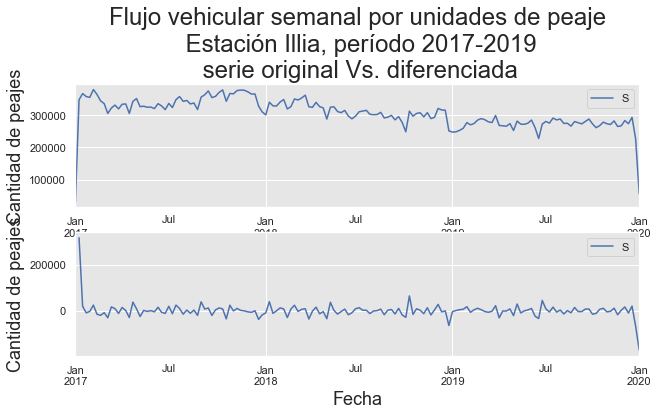

In [55]:
plt.figure(figsize=(9,5))
plt.subplot(2,1,1)
dataset_Illia_W.cantidad_peajes.plot(label='Serie original')
plt.title('Flujo vehicular semanal por unidades de peaje\n Estación Illia, período 2017-2019\n serie original Vs. diferenciada', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend('Serie original')
plt.subplot(2,1,2)
dataset_Illia_W.cantidad_peajes.diff().plot(label='Serie diferenciada')
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend('Serie diferenciada')
plt.show()

Una diferenciación parece suficiente. Vamos a descomponer la serie.

## Descomposición con modelos de statsmodels

Vamos a usar el seasonal_decompose de statsmodel,, considerando modelo aditivo, ya que asumimos que la estacionalidad tiene un claro patrón anual (la reducción del flujo vehícular en los meses de verano), y que la magnitud de esta fluctuación se mantiene contante. En period ponemos la duración del ciclo (52 semanas = 1 año)

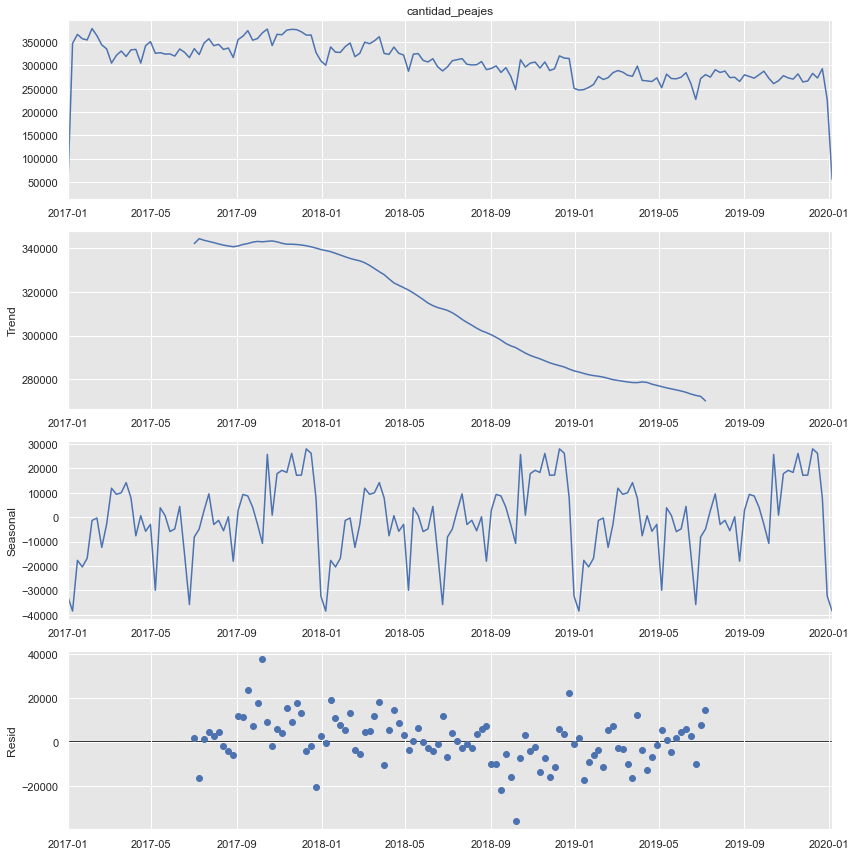

In [56]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = [12,12]

#para Seasonal decomposition using moving averages.
result_additive = seasonal_decompose(dataset_Illia_W.cantidad_peajes, period=52, model='additive')
result_additive.plot()
plt.show()

<AxesSubplot:xlabel='resid', ylabel='Density'>

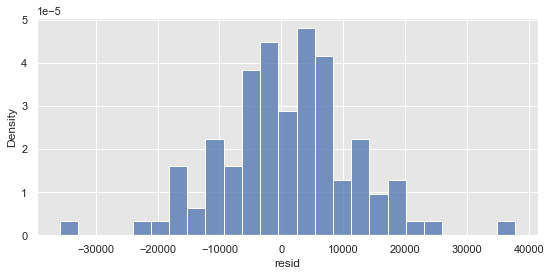

In [57]:
plt.figure(figsize=(8,4))
sns.histplot(result_additive.resid, stat= 'density', bins = 25, element='bars', fill=True)

A veces parece necesario tener buen ojo - y un poco de imaginación ;)-. Si miramos el gráfico de componente RESID, parece mostrar que el mismo es marcádamente (+) en la primera mitad, y luego, marcádamente (-). Desde luego, esto no es demasiado nítido, pero sería consistente con el quiebre que muestra la tendencia. ¿Que significa esto? que el residuo no parece independiente del tiempo. Aparte de esto, el ruido parece seguir una distribución normal. Recordemos esta idea: el modelo aditivo funciona cuando, en pocas palabras, las brechas entre pico y valle son constantes en el tiempo, que es lo que asumimos. Vamos a probar con un modelo multiplicativo. Luego los comparamos.

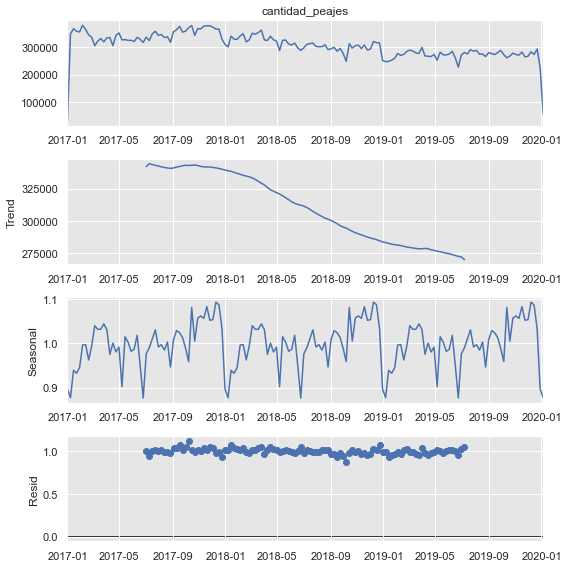

In [58]:
#para Seasonal decomposition using moving averages.
plt.rcParams['figure.figsize'] = [8,8]
result_multiplicative = seasonal_decompose(dataset_Illia_W.cantidad_peajes, period=52, model='multiplicative')
result_multiplicative.plot()
plt.show()

<AxesSubplot:xlabel='resid', ylabel='Density'>

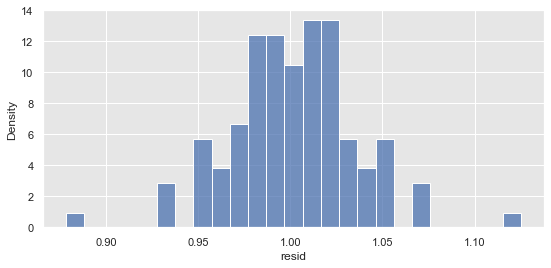

In [59]:
plt.figure(figsize=(8,4))
sns.histplot(result_multiplicative.resid, stat= 'density', bins = 25, element='bars', fill=True)

El gráfico de RESID y el histograma, muestran que el modelo es más multiplicativo que aditivo. El residuo se hace absolutamente independiente del tiempo.

# Autocorrelación y Autocorrelación Parcial

*In particular, autocorrelation
asks the more general question of whether there is a correlation between
any two points in a specific time series with a specific fixed distance between them* (Nielsen, 2020).

La predicción en series temporales implica asumir que, en gran medida, el futuro se comportará como el pasado. Una forma de observar en que grado esto es cierto, es observando la autocorrelación, y la autocorrelación parcial. La autocorrelación, como se desprende del nombre, es la correlación de los valores de la serie con los valores adoptados por la misma serie, pero en períodos anteriores (lags). La autocorrelación parcial nos permite medir la dependencia entre dos puntos distintos de la serie, neutralizando los efectos de los lags entre ellos.

Asimismo, los análisis de autocorrelación y autocorrelación parcial son insumo para modelos de tipo ARMA, ARIMA, y SARIMA, casa uno con sus particularidades. En nuestro caso, el modelo aplicable es el SARIMA, por las razones antes expuestas. Por ahora, vamos a concentrarnos en el análisis propiamente dicho. Recordemos: el primero nos permite descubrir el orden del proceso MA(), mientras que el segúndo, el del proceso AR().

In [60]:
#Importamos las librerías
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

Vamos a graficar ambas funciones, realizando las diferenciaciones necesarias. Para quitar tendencia realizamos 1, y otras 52 para quitar estacionalidad.

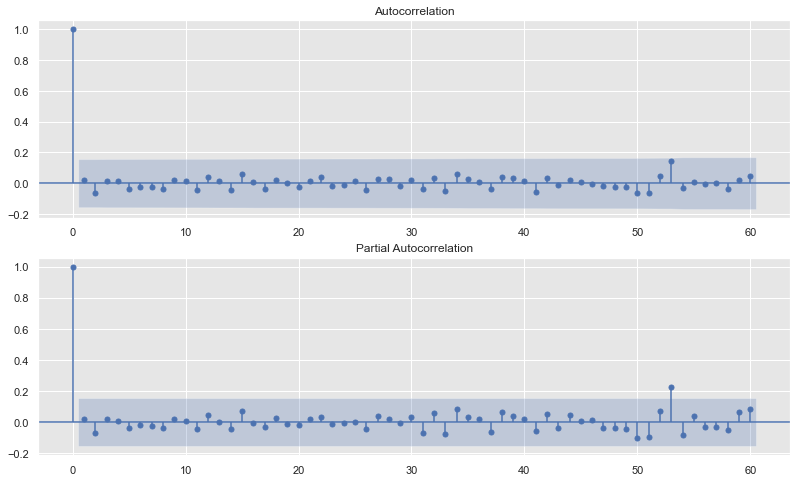

In [61]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig=plot_acf(dataset_Illia_W['cantidad_peajes'].diff().dropna(), lags=60, alpha= 0.05, ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(dataset_Illia_W['cantidad_peajes'].diff().dropna(), lags=60, alpha= 0.05, ax=ax2)
plt.show()

En caso de modelo SARIMA, tendríamos (p, d, q) = (0, 1, 0). Esto es lo que se llama un Random Walk. Ahora buscamos los parámetros para la estacionalidad. 

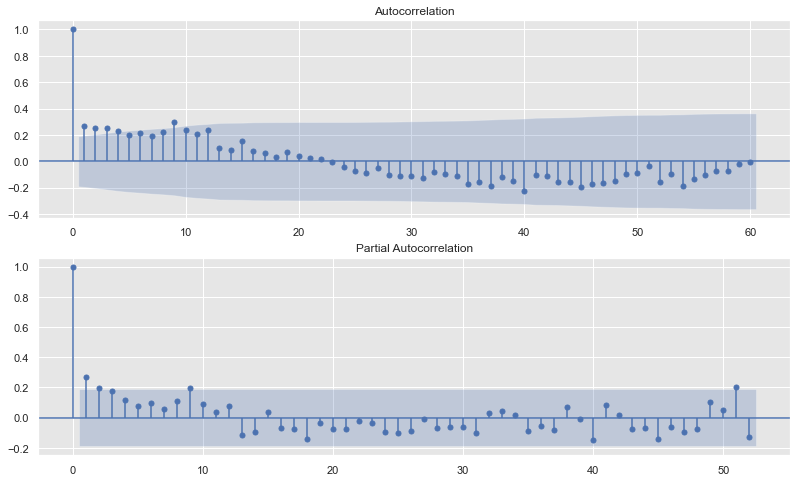

In [62]:
fig=plt.figure(figsize=(12,8))
ax1= fig.add_subplot(211)
fig=plot_acf(dataset_Illia_W['cantidad_peajes'].diff(52).dropna(), lags=60, ax=ax1)
ax2= fig.add_subplot(212)
fig=plot_pacf(dataset_Illia_W['cantidad_peajes'].diff(52).dropna(), lags=52, ax=ax2)
plt.show()

Los componentes (P, D, Q)m son: (1, 1, 3)52.

Ya tenemos todos los datos para lo que, eventualmente, sería un modelo SARIMA.

Vamos a pasar a la parte de modelización.

# **Modelo benchmark** 

**"a regression on past values to predict future values"** (Nielsen, 2020).

Como benchmark usaremos una regresión lineal, que simplemente nos aportará la ecuación de la recta que mejor ajuste a los datos. Es de esperar, por la poca flexibilidad del método, que obtengamos una valor de error elevado. Al respecto, los modelos los eveluaremos mediante RMSE y MAPE. 

Para comenzar, vamos a pasar las fechas a números.

In [63]:
dataset_Illia_W ['fecha_números'] = dataset_Illia_W.index.map(datetime.datetime.toordinal)

In [64]:
df_train = dataset_Illia_W.loc['2017-01-01':'2019-09-30']
df_test = dataset_Illia_W.loc['2019-10-01':]

In [65]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr_1 = lr.fit(df_train.fecha_números.values.reshape(-1, 1), df_train.cantidad_peajes)
y_pred_train= lr_1.predict(df_train.fecha_números.values.reshape(-1, 1))

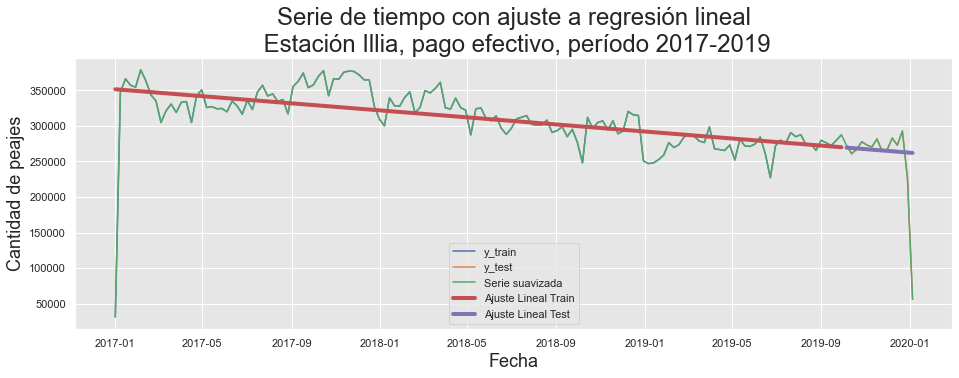

In [66]:
plt.figure(figsize = (14,5))
plt.plot(df_train.index, df_train.cantidad_peajes, label = 'y_train')
plt.plot(df_test.index, df_test.cantidad_peajes, label = 'y_test')
plt.plot(dataset_Illia_W.cantidad_peajes,label='Serie suavizada')
plt.plot(df_train.index, lr_1.predict(df_train.fecha_números.values.reshape(-1, 1)), lw = 4, label = 'Ajuste Lineal Train')
plt.plot(df_test.index, lr_1.predict(df_test.fecha_números.values.reshape(-1, 1)), lw = 4, label = 'Ajuste Lineal Test')
plt.title('Serie de tiempo con ajuste a regresión lineal\n Estación Illia, pago efectivo, período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend()
plt.show()

## Evaluación del modelo

In [67]:
from sklearn.metrics import mean_squared_error

def evaluar_regresion(model, X_train, X_test, y_train, y_test):
    
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print(f'Porcentaje del Error Absoluto medio en Train: {mape_train}')
    print(f'Porcentaje del Error Absoluto medio en Test: {mape_test}\n')

    ### GRAFICAMOS LOS RESULTADOS
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(y_train - y_train_pred, color= 'red', bins = 20, label = 'train')
    sns.histplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()
    
def evaluar_modelo(modelo, y_train, y_test, y_train_pred, y_test_pred):

    print('El modelo a evaluar: ', modelo)
    ### CALCULAMOS EL ERROR
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    mape_train = np.mean(np.abs((y_train - y_train_pred) / y_train)) * 100
    mape_test = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100

    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    print(f'Porcentaje del Error Absoluto medio en Train: {mape_train}')
    print(f'Porcentaje del Error Absoluto medio en Test: {mape_test}\n')

    ### GRAFICAMOS LOS RESULTADOS
    
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    sns.histplot(y_train -y_train_pred, color= 'red', bins = 20, label = 'train')
    sns.histplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test, y_test_pred, s =2)

    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
        ]

    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')

    plt.tight_layout()
    plt.show()

Raíz del error cuadrático medio en Train: 34380.80796935682
Raíz del error cuadrático medio en Test: 57062.74997429204
Porcentaje del Error Absoluto medio en Train: 12.404286968316109
Porcentaje del Error Absoluto medio en Test: 30.19735653622278



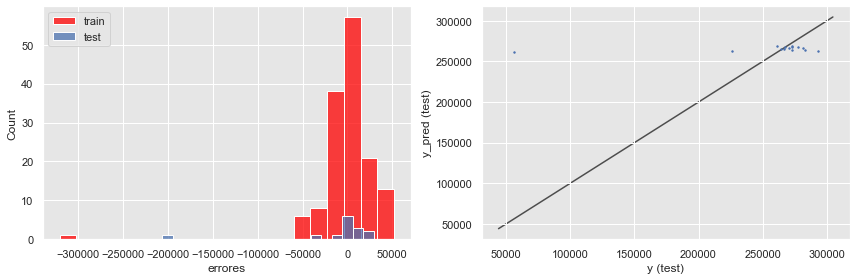

In [68]:
evaluar_regresion(lr_1, df_train['fecha_números'].values.reshape(-1, 1), df_test['fecha_números'].values.reshape(-1, 1),
df_train['cantidad_peajes'], df_test['cantidad_peajes'])

Con el benchmark obtenemos un error promedio de **34380 - 57062 peajes semanales (RMSE)**, que representan un **12% - 30% respecto de la media (MAPE)**, para el test/train set, respectivamente. Los outliers corresponden a registros de semanas incompletas. Sacando estos valores, los errores parecen seguir una distribución normal. Como vemos en el gráfico datos reales vs. predichos, el modelo sobreestima valores hasta los 26k peajes, y los subestima por encima de este valor. 

Vamos a pasar a un modelo SARIMA

# Modelo SARIMA

Ya nos referimos al modelo en el apartado 5.1.

Vamos a utilizar los parámetros que obtuvimos en el análisis de ACF y PACF, de modo que ya trabajaremos con un modelo optimizado

In [69]:
#Dropeamos columna que no necesitamos
#dataset_Illia_W = dataset_Illia_W.drop(columns=['fecha_números'])

#separamos los datasets
df_train = dataset_Illia_W.loc['2017-01-01':'2019-09-30']
df_test = dataset_Illia_W.loc['2019-10-01':]

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarima= sm.tsa.statespace.SARIMAX(endog=df_train['cantidad_peajes'], order=(0,1,0), 
                                 seasonal_order=(1,1,3,52),
                                 enforce_stationarity=False,
                                 enforce_invertibility=False).fit(dis=-1)

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


Ya tenemos el modelo entrenado. Vamos a separar en train/test y crear las variables con las predicciones para cada uno

In [70]:
y_train_pred = sarima.predict('2017-01-01', '2019-10-01')[:-1]
y_test_pred = sarima.predict('2019-09-30', '2019-12-31')[0:-1]
df_train ['y_train_pred'] = y_train_pred
df_test ['y_test_pred'] = y_test_pred

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Vamos a graficar la serie original y los valores predichos por el modelo

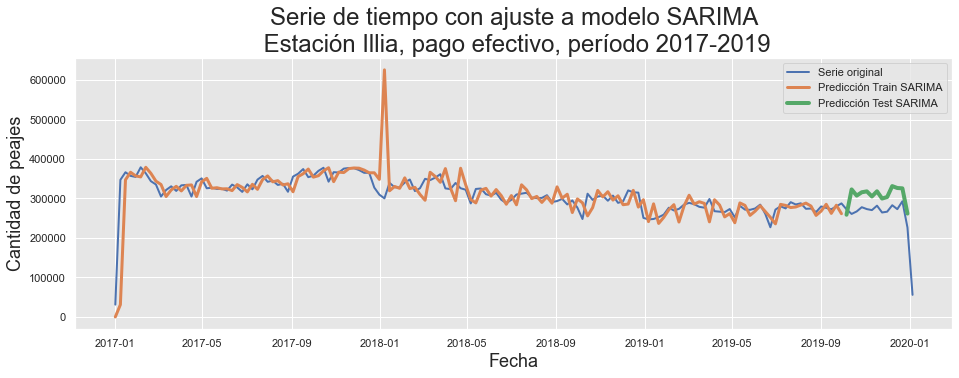

In [71]:
plt.figure(figsize = (14,5))
plt.plot(dataset_Illia_W.index, dataset_Illia_W.cantidad_peajes, lw = 2, label = 'Serie original')
plt.plot(df_train.index, df_train.y_train_pred, lw = 3, label = 'Predicción Train SARIMA')
plt.plot(df_test.index, df_test.y_test_pred, lw = 4, label = 'Predicción Test SARIMA')
plt.title('Serie de tiempo con ajuste a modelo SARIMA\n Estación Illia, pago efectivo, período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
plt.legend()
plt.show()

Tenemos que sacar valor nulo del test

In [72]:
df_test.dropna(inplace=True)

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


## Evaluación del modelo

Vamos a evaluar RMSE y MAPE, la distribución de errores, y la comparación gráfica entre valores reales y predichos

El modelo a evaluar:  SARIMA
Raíz del error cuadrático medio en Train: 42974.79876074156
Raíz del error cuadrático medio en Test: 40938.47431206981
Porcentaje del Error Absoluto medio en Train: 7.070354542480482
Porcentaje del Error Absoluto medio en Test: 14.64858732223705



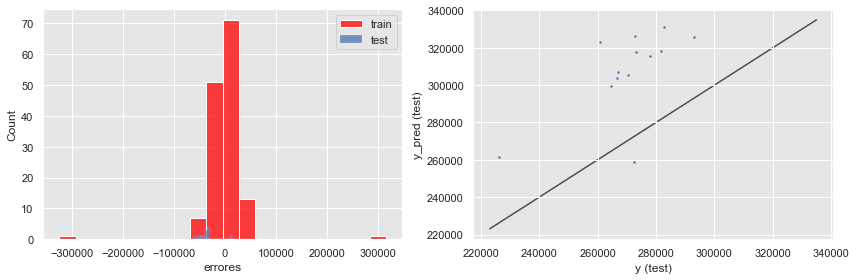

In [73]:
evaluar_modelo('SARIMA', df_train.cantidad_peajes, df_test.cantidad_peajes, df_train.y_train_pred, df_test.y_test_pred)

Obtenemos un error promedio de **42974 - 40938 peajes semanales (RMSE), que representan un 7,1% - 14,6% respecto de la media (MAPE), para el test/train set, respectivamente**. Aquí llama la atención que, **si bien el RMSE train>RMSE test, el MAPE train< MAPE test**. Si nos guiásemos por la primer métrica, podríamos decir que el modelo es robusto. Sin embargo, **aquella relación es lógica**, mirando los valores que adopta la serie (mucho menores para el test), y entendiendo que el RMSE es un valor absoluto. Es por eso que nos inclinamos hacia el **MAPE como la métrica más confiable** en estos casos, ya que expresa el error como porcentaje de la base. Desde este punto, creemos que el elevado MAPE de test respecto del test se debe fundamentalmente a los pocos datos, y a estos pocos datos tocan precisamente en el inicio del ciclo estacional (el fin de año).

Nuevamente, los errores parecen seguir una distribución normal. En el gráfico de datos reales vs. predichos, **la predicción sistemáticamente sobreestima los valores**. 

El **SARIMA parece tener muy buen desempeño**. Vamos a pasar al último modelo que trabajaremos en este proyecto.

# **Prophet**

Vamos a comenzar armando el dataset específico para trabajar con Prophet, cambiando el índice de las fechas por 'ds' y la variable 'cantidad_pasos' por 'y'. Una vez hecho el reemplazo, vamos a sacar las variables que no vamos a usar, armando una máscara:

In [74]:
dataset_Illia_W['ds']= dataset_Illia_W.index
dataset_Illia_W['y']= dataset_Illia_W['cantidad_peajes']

mask1= dataset_Illia_W.drop(columns=['cantidad_peajes'])

Separemos el Train/Test Split tomando el último trimestre del 2019 (01-10-2019 al 31/12/2019) como Test, como se solicita, y del 01-01-2017 al 30-09-2019 como Train, específicamente para Prophet con sus variables características 'ds' e 'y'.

In [75]:
threshold_date = pd.to_datetime('2019-10-01')
mask = mask1['ds'] < threshold_date

df_train = mask1[mask][['ds', 'y']]
df_test = mask1[~ mask][['ds', 'y']]

## Prophet sin optimizar

Ahora vamos a aplicar Prophet. Iniciamos creando una función para realizar el **fit**


In [76]:
def fit_model(dataframe, yearly_seasonality=True):
    m = Prophet()
    m = m.fit(dataframe)
    return m
    
m = fit_model(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Hacemos lo propio para el **predict**

In [77]:
def predict_model(m, dataframe):
    #future= m.make_future_dataframe(periods=12)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast
    
y_pred_tr = predict_model(m, df_train)
y_pred_tst = predict_model(m, df_test)

Hacemos un merge de los valores predichos para graficarlos

In [78]:
y_pred_ = pd.concat([y_pred_tr, y_pred_tst])

In [79]:
from fbprophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, y_pred_)

Prophet tiene integrada la funcionalidad de detectar outliers. En nuestro caso, el modelo se ingestó con una seria preprocesada. Aún así, vamos a integrar esta funcionalidad a nuestro análisis.

In [80]:
import altair as alt

def detect_anomalies(forecast):
    forecasted = forecast[['ds', 'trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

pred_tr = detect_anomalies(y_pred_tr)
pred_tst = detect_anomalies(y_pred_tst)

pred_ = pd.concat([pred_tr, pred_tst])

alt.data_transformers.enable('default', max_rows=None)

DataTransformerRegistry.enable('default')

In [81]:
def plot_anomalies(forecasted):
    interval = alt.Chart(forecasted).mark_area(interpolate="basis", color = '#7FC97F').encode(
    x=alt.X('ds:T',  title ='date'),
    y='yhat_upper',
    y2='yhat_lower',
    tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive().properties(
        title='Detección de Outliers'
    )

    fact = alt.Chart(forecasted[forecasted.anomaly==0]).mark_circle(size=15, opacity=0.7, color = 'Black').encode(
        x='ds:T',
        y=alt.Y('fact', title='cantidad de pasos'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper']
    ).interactive()

    anomalies = alt.Chart(forecasted[forecasted.anomaly==1]).mark_circle(size=15, color = 'Red').encode(
        x='ds:T',
        y=alt.Y('fact', title='cantidad de pasos'),    
        tooltip=['ds', 'fact', 'yhat_lower', 'yhat_upper'],
        size = alt.Size( 'importance', legend=None)
    ).interactive()

    return alt.layer(interval, fact, anomalies)\
              .properties(width=870, height=450)\
              .configure_title(fontSize=20)
              

plot_anomalies(pred_)

alt.LayerChart(...)

Vamos a observar otra de las funcionalidades de Prophet. Estos son tópico en los que aún no hemos profundizado

In [82]:
from fbprophet.diagnostics import cross_validation

def cv_results_model(m):
    cv_results = cross_validation (m, horizon = '90 days')
    return cv_results
    
cv_results = cv_results_model(m)

INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-01-07 00:00:00 and 2019-07-01 00:00:00


In [83]:
cv_results

ds           yhat     yhat_lower     yhat_upper       y     cutoff
0   2018-01-14  459712.082457  422058.933843  497325.136143  339652 2018-01-07
1   2018-01-21  525871.268315  490412.651007  563156.196500  328359 2018-01-07
2   2018-01-28  540280.355075  504104.803182  577557.610018  327887 2018-01-07
3   2018-02-04  521327.155532  483631.842024  556029.255100  340275 2018-01-07
4   2018-02-11  501240.643611  465529.854382  537095.887700  348044 2018-01-07
..         ...            ...            ...            ...     ...        ...
162 2019-09-01  247970.619470  210496.314345  282248.766818  279775 2019-07-01
163 2019-09-08  250233.439196  216507.804679  286414.890647  276271 2019-07-01
164 2019-09-15  253921.814065  217654.689182  285789.175333  272592 2019-07-01
165 2019-09-22  255273.854177  222275.571973  287241.156217  279927 2019-07-01
166 2019-09-29  251000.637986  215005.138643  284052.577226  287568 2019-07-01

[167 rows x 6 columns]

In [84]:
from fbprophet.diagnostics import performance_metrics

df_p = performance_metrics(cv_results)
df_p.head()

horizon           mse          rmse           mae      mape     mdape  \
0  9 days  1.548821e+09  39355.064268  27840.458919  0.093864  0.062511   
1 10 days  1.539837e+09  39240.757942  27359.127475  0.092338  0.062511   
2 11 days  1.538596e+09  39224.942821  27173.708026  0.092238  0.068394   
3 12 days  1.344991e+09  36674.120828  24378.105121  0.080111  0.060899   
4 13 days  1.437996e+09  37920.922247  25926.480562  0.085612  0.075345   

   coverage  
0    0.8750  
1    0.8750  
2    0.8750  
3    0.9375  
4    0.8750

In [85]:
df_p.mape.mean()*100

13.508023148072951

In [86]:
df_p.rmse.mean()

55946.30611623376

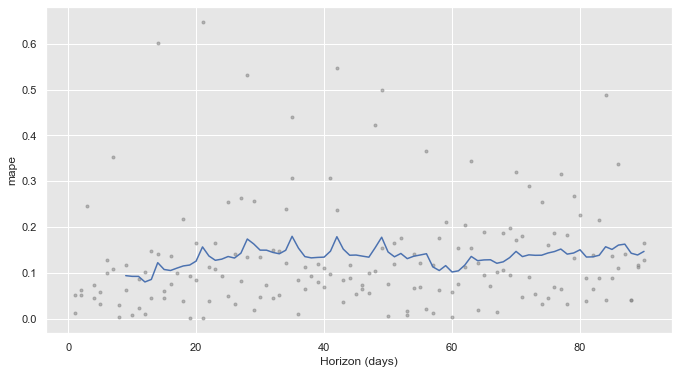

In [87]:
from fbprophet.plot import plot_cross_validation_metric

fig = plot_cross_validation_metric(cv_results, metric='mape')

## Evaluación del modelo

El modelo a evaluar:  Prophet por defecto
Raíz del error cuadrático medio en Train: 27125.490465685525
Raíz del error cuadrático medio en Test: 41004.991808456034
Porcentaje del Error Absoluto medio en Train: 9.836764444040234
Porcentaje del Error Absoluto medio en Test: 21.53889201273043



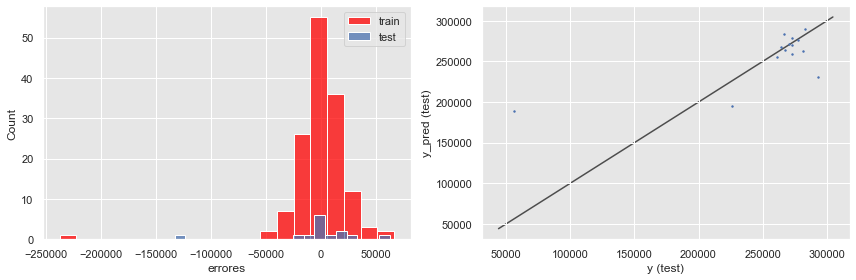

In [88]:
evaluar_modelo('Prophet por defecto', y_pred_tr['fact'], y_pred_tst['fact'], y_pred_tr['yhat'], y_pred_tst['yhat'])

Obtenemos un desempeño que, medido por ambas métricas, resulta peor que el de SARIMA (set test). Un punto a favor: los errores también se distribuyen normalmente, pero a su vez, parecen ser aleatorios, alternando + y -. 

Vamos a probar con hiperparámetros optimizados. Recordatorio: no vamos a usar la posibilidad de la estacionalidad compleja, que Prophet posee. Eso queda para el proyecto 4.

## Optimización de Hiperparámetros Prophet

In [89]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode':('multiplicative','additive')
}
              
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  

for params in all_params:
    m = Prophet(**params).fit(df_train) 
    df_p = performance_metrics(cv_results, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

    changepoint_prior_scale  seasonality_prior_scale seasonality_mode  \
0                     0.001                     0.01   multiplicative   
1                     0.001                     0.01         additive   
2                     0.001                     0.10   multiplicative   
3                     0.001                     0.10         additive   
4                     0.001                     1.00   multiplicative   
5                     0.001                     1.00         additive   
6                     0.001                    10.00   multiplicative   
7                     0.001                    10.00         additive   
8                     0.010                     0.01   multiplicative   
9                     0.010                     0.01         additive   
10                    0.010                     0.10   multiplicative   
11                    0.010                     0.10         additive   
12                    0.010                     1.0

In [90]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


Vamos a usar los parámetros ya optimizados para comparar con el modelo Prophet original

In [91]:
def fit_model(dataframe, yearly_seasonality=True):
    m_ = Prophet(changepoint_prior_scale= 0.001, seasonality_prior_scale= 0.01,
                 seasonality_mode= 'multiplicative')
    m_ = m_.fit(dataframe)
    return m_
    
m1 = fit_model(df_train)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [92]:
y_pred_tr1 = predict_model(m1, df_train)
y_pred_tst1 = predict_model(m1, df_test)

In [93]:
cv_results1 = cv_results_model(m1)

INFO:fbprophet:Making 13 forecasts with cutoffs between 2018-01-07 00:00:00 and 2019-07-01 00:00:00


In [94]:
y_pred_tr1.head()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 2017-01-01  351839.595573  282274.024834  361017.860720  351839.595573   
1 2017-01-08  351258.390769  285248.879640  368751.740659  351258.390769   
2 2017-01-15  350677.185965  304005.695998  381000.529780  350677.185965   
3 2017-01-22  350095.981160  311780.941285  393930.355399  350095.981160   
4 2017-01-29  349514.776356  315881.584393  396358.765611  349514.776356   

     trend_upper  multiplicative_terms  multiplicative_terms_lower  \
0  351839.595573             -0.083805                   -0.083805   
1  351258.390769             -0.072380                   -0.072380   
2  350677.185965             -0.031101                   -0.031101   
3  350095.981160              0.006846                    0.006846   
4  349514.776356              0.019409                    0.019409   

   multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                   -0.083805 -0.083805     -0.083805     -0.083805   
1                   -0.072380 -0.072380     -0.072380     -0.072380   
2                   -0.031101 -0.031101     -0.031101     -0.031101   
3                    0.006846  0.006846      0.006846      0.006846   
4                    0.019409  0.019409      0.019409      0.019409   

   additive_terms  additive_terms_lower  additive_terms_upper           yhat  \
0             0.0                   0.0                   0.0  322353.574451   
1             0.0                   0.0                   0.0  325834.235636   
2             0.0                   0.0                   0.0  339770.886658   
3             0.0                   0.0                   0.0  352492.640304   
4             0.0                   0.0                   0.0  356298.357795   

     fact  
0   31183  
1  347212  
2  366413  
3  357215  
4  354581

In [95]:
y_pred_tst1.head()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 2019-10-06  268146.103762  229354.249224  310115.963908  268146.103762   
1 2019-10-13  267564.898957  229543.986231  305814.205102  267564.898946   
2 2019-10-20  266983.694153  228587.289534  312978.518462  266983.694123   
3 2019-10-27  266402.489349  236347.299690  311641.785014  266402.489288   
4 2019-11-03  265821.284545  234170.124855  316047.284691  265821.284452   

     trend_upper  multiplicative_terms  multiplicative_terms_lower  \
0  268146.103762              0.007441                    0.007441   
1  267564.898963              0.004500                    0.004500   
2  266983.694173              0.013249                    0.013249   
3  266402.489399              0.027705                    0.027705   
4  265821.284624              0.033463                    0.033463   

   multiplicative_terms_upper    yearly  yearly_lower  yearly_upper  \
0                    0.007441  0.007441      0.007441      0.007441   
1                    0.004500  0.004500      0.004500      0.004500   
2                    0.013249  0.013249      0.013249      0.013249   
3                    0.027705  0.027705      0.027705      0.027705   
4                    0.033463  0.033463      0.033463      0.033463   

   additive_terms  additive_terms_lower  additive_terms_upper           yhat  \
0             0.0                   0.0                   0.0  270141.359522   
1             0.0                   0.0                   0.0  268768.813501   
2             0.0                   0.0                   0.0  270521.087848   
3             0.0                   0.0                   0.0  273783.186742   
4             0.0                   0.0                   0.0  274716.579089   

     fact  
0  272483  
1  260840  
2  267147  
3  277903  
4  273129

In [96]:
df_p1 = performance_metrics(cv_results1)
df_p1.head()

horizon           mse          rmse           mae      mape     mdape  \
0  9 days  9.144052e+08  30239.133282  24936.271528  0.087850  0.075879   
1 10 days  8.928933e+08  29881.319505  24263.294157  0.085523  0.075879   
2 11 days  1.041198e+09  32267.604130  26343.950812  0.094539  0.079262   
3 12 days  7.123416e+08  26689.727872  22838.740093  0.079207  0.074255   
4 13 days  6.523958e+08  25542.040180  21076.542170  0.072642  0.073117   

   coverage  
0    0.9375  
1    0.9375  
2    0.8750  
3    0.9375  
4    0.9375

In [97]:
df_p1.mape.mean()*100

9.695659939362937

In [98]:
df_p1.rmse.mean()

33327.48699510325

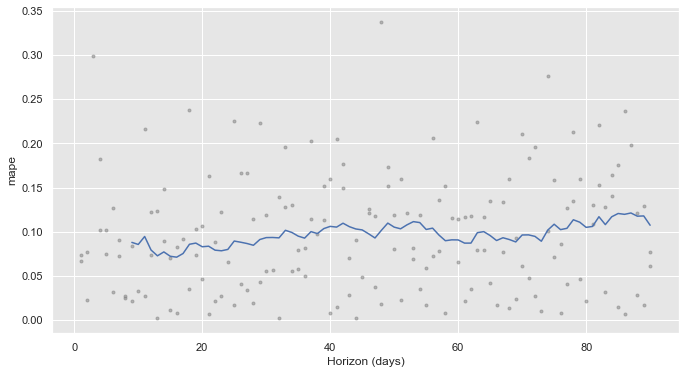

In [99]:
fig1 = plot_cross_validation_metric(cv_results1, metric='mape')

In [100]:
pred = pd.concat([y_pred_tr1, y_pred_tst1])

In [101]:
plot_plotly(m1, pred)

sns.set_style('darkgrid', {'axes.facecolor': '.9'})
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline

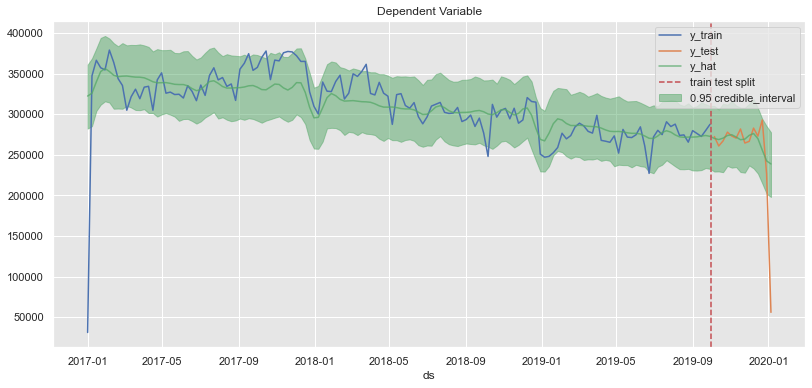

In [102]:
threshold_date = pd.to_datetime('2019-10-01')
mask = mask1['ds'] < threshold_date

df_train_1 = mask1[mask][['ds', 'y']]
df_test_1 = mask1[~ mask][['ds', 'y']]

mask2 = pred['ds'] < threshold_date

forecast_train = pred[mask2]
forecast_test = pred[~ mask2]

fig, ax = plt.subplots(figsize=(12,6))
ax.fill_between(
    x=pred['ds'],
    y1=pred['yhat_lower'],
    y2=pred['yhat_upper'],
    color=sns_c[2], 
    alpha=0.50,
    label=r'0.95 credible_interval'
)

sns.lineplot(x='ds', y='y', label='y_train', data=df_train_1, ax=ax)
sns.lineplot(x='ds', y='y', label='y_test', data=df_test_1, ax=ax)
sns.lineplot(x='ds', y='yhat', label='y_hat', color=sns_c[2], alpha=0.75, data=pred, ax=ax)
ax.axvline(threshold_date, color=sns_c[3], linestyle='--', label='train test split')
ax.legend(loc='upper right')
ax.set(title='Dependent Variable', ylabel='');

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\fbprophet\plot.py:422: UserWarning:

FixedFormatter should only be used together with FixedLocator



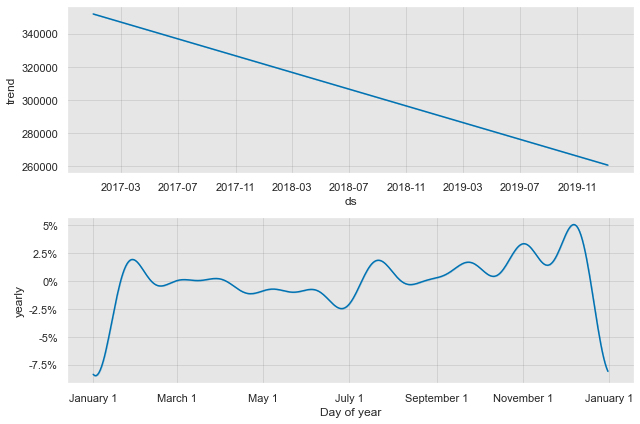

In [103]:
fig = m1.plot_components(pred)

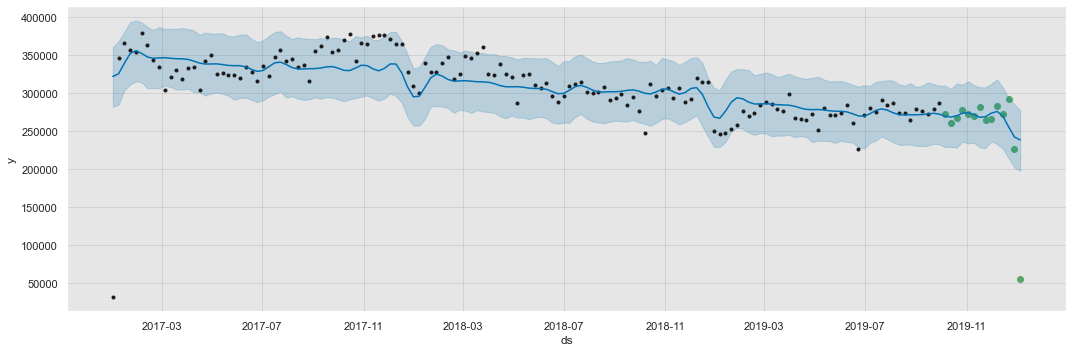

In [104]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test_1.ds, df_test_1.y, color='g')
fig = m1.plot(pred,ax=ax)
plt.show()

## Evaluación del Prophet optimizado

Vamos a evaluar el Prophet optimizado

El modelo a evaluar:  Prophet optimizado
Raíz del error cuadrático medio en Train: 31172.29449325122
Raíz del error cuadrático medio en Test: 50313.97195896649
Porcentaje del Error Absoluto medio en Train: 11.264610021841728
Porcentaje del Error Absoluto medio en Test: 26.198647224549525



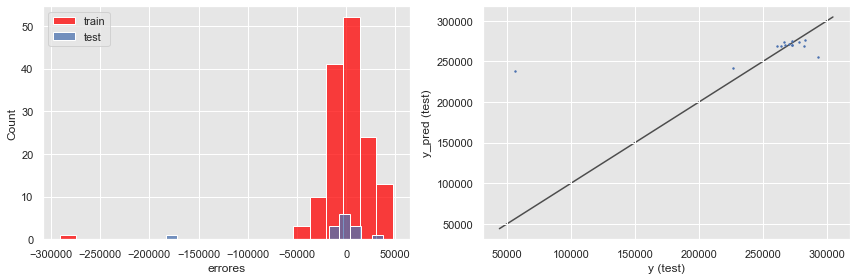

In [105]:
evaluar_modelo('Prophet optimizado', y_pred_tr1['fact'], y_pred_tst1['fact'], y_pred_tr1['yhat'], y_pred_tst1['yhat'])

El desempeño del Prophet optimizado no es mejor al entrenado por defecto.

## Prueba: Prophet con changepoint


En reiteradas oportunidades hicimos notar el posible cambio de tendencia con el aumento de precio del peaje el 29/03/2018. Vamos a intentar un nuevo Prophet fijando manualmente el changepoint en esta fecha, y lo compararemos con el Prophet regular

In [106]:
m2 = Prophet(changepoints=['2018-03-29'])

m2 = m2.fit(df_train)

pred_tr_ch = predict_model(m2, df_train)
pred_tst_ch = predict_model(m2, df_test)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


El modelo a evaluar:  Prophet con changepoint
Raíz del error cuadrático medio en Train: 28398.782414971425
Raíz del error cuadrático medio en Test: 40347.975645818835
Porcentaje del Error Absoluto medio en Train: 10.277739596465132
Porcentaje del Error Absoluto medio en Test: 21.501523106058286



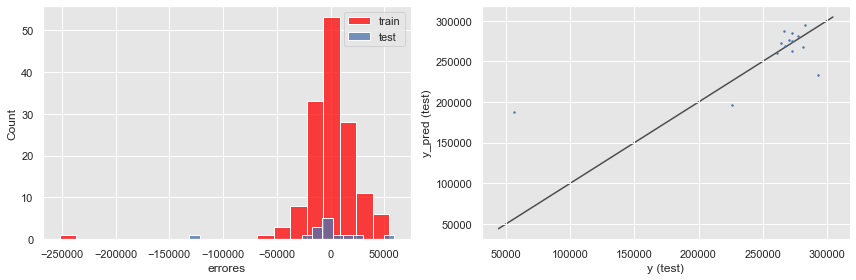

In [107]:
evaluar_modelo('Prophet con changepoint', pred_tr_ch['fact'], pred_tst_ch['fact'], pred_tr_ch['yhat'], pred_tst_ch['yhat'])

El modelo tiene una muy leve mejora en el test, respecto del Prophet por defecto, pero aún lejos del desempeño del SARIMA. Este último será el que usaremos para el forecast del 2020.

# **Forecast 2020**

Vamos a realizar el pronóstico del año 2020 con el modelo sarima entrenado en el punto 8, pero lo reentrenaremos con los tres años disponibles, de modo que la predicción resultante sea exclusiva para 2020. 

In [108]:
#Dropeamos columna que no necesitamos
dataset_Illia_W = dataset_Illia_W.drop(columns=['fecha_números', 'ds', 'y'])

#Quito último valor
mask= dataset_Illia_W.iloc[1:-1]

In [109]:
sarima_forecast= sm.tsa.statespace.SARIMAX(endog=mask['cantidad_peajes'], order=(0,1,0), 
                                 seasonal_order=(1,1,3,52),
                                           enforce_stationarity=False,
                                          enforce_invertibility=False).fit(dis=-1)

C:\Users\BagattinMarciano\miniconda3\envs\prophet\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:867: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.



In [110]:
#Pronóstico para las próximas 52 semanas
forecast_values= sarima_forecast.get_forecast(steps=52)

#Intervalos de confianza para los valores pronosticados
forecast_ci= forecast_values.conf_int()

Ya entrenamos el modelo con todos los datos de 2017, 2018 y 2019. Vamos a graficar la serie original + el pronóstico 2020

<Figure size 576x576 with 0 Axes>

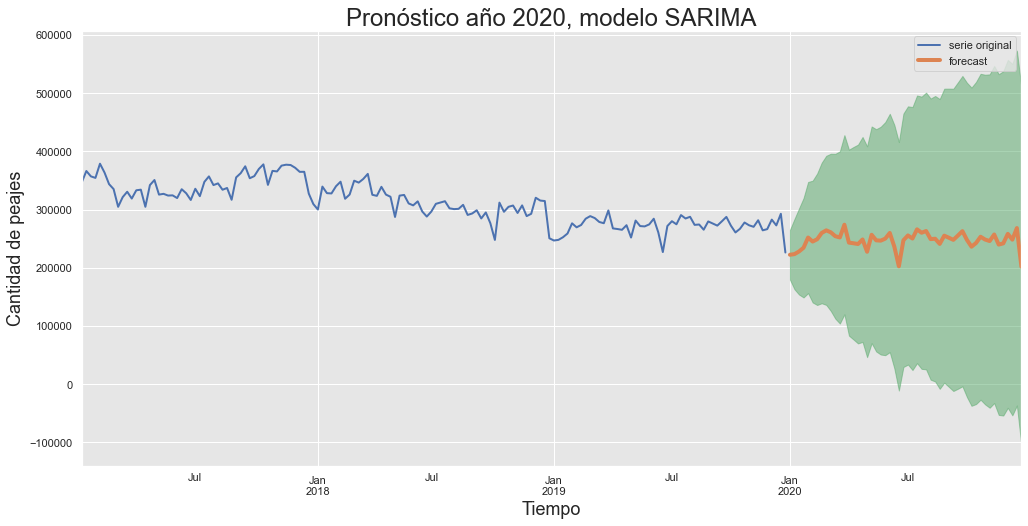

In [111]:
#Grafico la serie original
plt.figure(facecolor='#d8dcd6')
ax= mask.plot(figsize = (15,8), lw=2)
#Grafico el pronóstico 2020
forecast_values.predicted_mean.plot(ax=ax, lw=4)
#Grafico los intervalos de confianza
ax.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='g', alpha=.5)
#Etiquetas y título
ax.set_xlabel('Tiempo', fontsize=18)
ax.set_ylabel('Cantidad de peajes', fontsize=18)
ax.set_title('Pronóstico año 2020, modelo SARIMA', fontsize=24)
plt.legend(['serie original','forecast'])
plt.show()

El pronóstico parece consistente con los valores de la serie original, respetando la tendencia y la estacionalidad observada en el período 2017-2019. 

Hemos mencionado que la clave de los modelos de predicción en series de tiempo se basan en el supuesto de que el futuro se comportará como el pasado. Eventos como el Covid-19 demuestran lo frágil que aquel supuesto puede ser.

# Otros tópicos

## Comparación entre distintas estaciones de peajes

**¿El descenso en el pago en efectivo en Illia se replicará en el resto de estaciones?** Vamos a graficar las más importantes: Avellaneda, Dellepiane, e Illia.

In [112]:
mask_eftv = dataset.forma_pago=='EFECTIVO'
data_eftv = dataset[mask_eftv]
mask_Tel = dataset.forma_pago=='TELEPASE'
data_tel = dataset[mask_Tel]

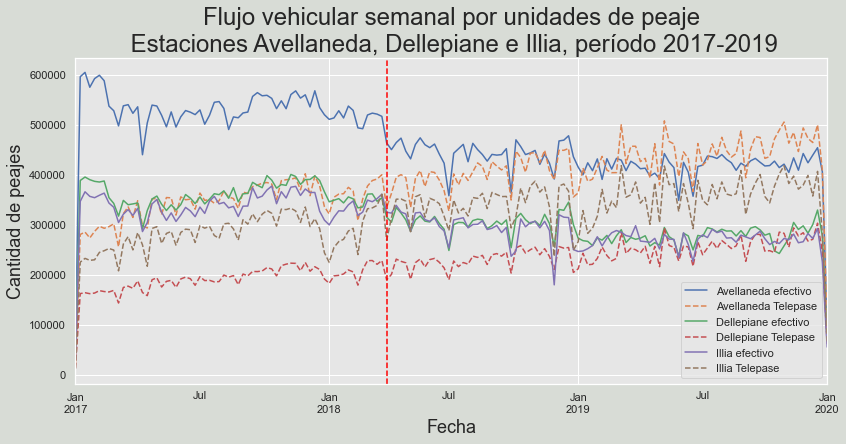

In [113]:
plt.figure(facecolor='#d8dcd6')
data_eftv_AVEL = data_eftv[(data_eftv['estacion']== 'Avellaneda')].resample('W', on='fecha')['cantidad_pasos'].sum().plot(figsize = (12,6))
data_tel_AVEL = data_tel[(data_tel['estacion']== 'Avellaneda')].resample('W', on='fecha')['cantidad_pasos'].sum().plot(linestyle='--', figsize = (12,6))
data_eftv_DELLE = data_eftv[(data_eftv['estacion']== 'Dellepiane')].resample('W', on='fecha')['cantidad_pasos'].sum().plot(figsize = (12,6))
data_tel_DELLE = data_tel[(data_tel['estacion']== 'Dellepiane')].resample('W', on='fecha')['cantidad_pasos'].sum().plot(linestyle='--', figsize = (12,6))
data_eftv_ILL = data_eftv[(data_eftv['estacion']== 'Illia')].resample('W', on='fecha')['cantidad_pasos'].sum().plot(figsize = (12,6))
data_tel_ILL = data_tel[(data_tel['estacion']== 'Illia')].resample('W', on='fecha')['cantidad_pasos'].sum().plot(linestyle='--', figsize = (12,6))
plt.title('Flujo vehicular semanal por unidades de peaje\n Estaciones Avellaneda, Dellepiane e Illia, período 2017-2019', fontsize=24)
plt.xlabel('Fecha', fontsize=18)
plt.ylabel('Cantidad de peajes', fontsize=18)
#plt.ylim(150000,450000)
threshold_date = pd.to_datetime('2018-03-29')
plt.axvline(threshold_date, color='red', linestyle='--')
plt.legend(['Avellaneda efectivo', 'Avellaneda Telepase','Dellepiane efectivo', 'Dellepiane Telepase', 'Illia efectivo', 'Illia Telepase'])
plt.show()

Observamos el mismo comportamiento en todas las series. Lo más llamativo es que **las magnitudes del trade-off entre pago en efectivo y Telepase son muy similares**: 

- Avellaneda: el pago con Telepeaje respecto de efectivo, pasa de ser un 50% inferior a ser un 10% superior. 
- Illia: el pago con Telepeaje respecto de efectivo, pasa de ser un 25% inferior a ser un 33% superior. 
- Dellepiane: el pago con Telepeaje respecto de efectivo, pasa de ser un 58% inferior a alcanzar el mismo nivel.

## Modelos multivariados

Hemos trabajado con modelos univariados. Eso nos lleva a considerar al tiempo como el responsable de los cambios en la variable dependiente. Más bien, a considerar que hay **ciertos efectos que tienden a mitigarse o intensificarse con el paso del tiempo**. Por ejemplo, el incremento de la temperatura media durante los últimos 50 años no es un fenómeno atribuible al tiempo, pero este lo hace evidente. Tampoco las poblaciones crecen por el simple paso del tiempo. Crecen porque hay condiciones que lo favorecen (o desalientan). Basta con mirar el bono demográfico en Argentina, o el envejecimiento poblacional en la Europa desarrollada. En nuestro caso, por ejemplo, la reducción en la cantidad de peajes abonados en efectivo puede deberse a los cambios en los precios de los peajes, de las lluvias, o del valor de combustible, por citar algunos. A pesar de lo anterior, las series de tiempo con modelos univariados pueden llevarnos a estimar, con cierta precisión, como será ese futuro, si todo lo demás continúa comportandose como hasta ahora.

Es insuficiente. Como mencionamos antes, el objetivo del presente proyecto no es demasiado ambicioso. Para el próximo proyecto evaluaremos un SARIMA con variables exógenas (exog), y un Random Forest.

# What´s next?

En el desarrollo del trabajo nos enfrentamos con varios desafíos. El primero fue la estacionalidad compleja, a la cuál debimos "sortear" con resampleo semanal. También indagamos en modelos como SARIMA y sus complejidades, asi como con la versatilidad de Prophet. Escribimos nuestras primeras funciones, y mejoramos el uso del groupby. ¿Qué sigue? Para el próximo proyecto buscaremos desarrollar:
- Modelos con estacionalidad compleja (Prophet yearly y weekly, TBATS)
- Redes neuronales (RNN y LSTM)
- Modelos multivariados (SARIMA con variable exógena, Random Forest)

De entre las preguntas que dejamos planteadas: ¿que relación tienen las variaciones el precio del combustible y de la tarifa de peajes en la variación de la cantidad demandada de pejaes?

## Qué esperamos encontrar?

La posibilidad de trabajar con modelos de estacionalidad compleja nos permitiría estimar con precisión sobre un resampleo diario de la serie, algo que deliberadamente buscamos evitar en esta entrega. 

Por otra parte, la pregunta que dejamos planteada está intrinsecamente vinculada a los modelos multivariados. Allí, esperamos obtener las series de valores para combustibles, y de las tarifas de peajes, e incorporarlas a los modelos. La hipótesis de trabajo es que esperamos encontrar regresores para estas variables, que resulten estadísticamente significativos para explicar las variaciones en las cantidades demandadas de peajes. Asimismo, pensamos trabajar con una ventana de tiempo más amplia que la utilizada en este proyecto.

# Fuentes de información

- Nielsen, Aileen. (2020). *Practical Time Series Analysis: Prediction with Statistics & Machine Learning*. O’Reilly Media, Inc.
- Taylor, S. J., & Letham, B. (2018). *Forecasting at scale*. The American Statistician, 72(1), 37-45. https://peerj.com/preprints/3190v2/
- Xie, T., & Ding, J. (2020). *Forecasting with Multiple Seasonality*. arXiv preprint arXiv:2008.12340.. https://arxiv.org/pdf/2008.12340.pdf
- Blaconá, M. T., & Andreozzi, L. (2013). *Modelos para series de tiempo con estacionalidad compleja*. https://www.fcecon.unr.edu.ar/web-nueva/sites/default/files/u16/Decimocuartas/blacona_andreozzi_modelos_para_series_de_tiempo.pdf
- López Sáez, José Ignacio, *Análisis de series de tiempo: pronóstico de demanda de uso de aeropuertos en Argentina al 2022*; Trabajo final integrador; ITBA. https://ri.itba.edu.ar/bitstream/handle/123456789/1230/TFI%20-%20Jose_%20Ignacio%20Lo_pez%20Sa_ez.pdf?sequence=1&isAllowed=y

- https://otexts.com/fpp2/complexseasonality.html
- https://www.kaggle.com/wwymak/forecasting-with-prophet-not-complete-yet/data
- https://www.kaggle.com/gulyvz/time-series-forecasting-and-analysis-part-1
- https://medium.com/@sigmundojr/seasonality-in-python-additive-or-multiplicative-model-d4b9cf1f48a7
- https://medium.com/data-science-in-your-pocket/preprocessing-for-time-series-forecasting-3a331dbfb9c2
- https://medium.com/intive-developers/forecasting-time-series-with-multiple-seasonalities-using-tbats-in-python-398a00ac0e8a
- https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c
- https://medium.com/analytics-vidhya/time-series-analysis-using-prophet-in-python-part-2-hyperparameter-tuning-and-cross-validation-88e7d831a067
- https://towardsdatascience.com/almost-everything-you-need-to-know-about-time-series-860241bdc578
- https://towardsdatascience.com/implementing-facebook-prophet-efficiently-c241305405a3
- https://towardsdatascience.com/anomaly-detection-time-series-4c661f6f165f
- https://towardsdatascience.com/time-series-decomposition-and-statsmodels-parameters-69e54d035453
- https://towardsdatascience.com/how-to-forecast-sales-with-python-using-sarima-model-ba600992fa7d
- https://www.datasciencesmachinelearning.com/2019/01/arimasarima-in-python.html
- https://www.kdnuggets.com/2018/09/end-to-end-project-time-series-analysis-forecasting-python.html
- https://stats.stackexchange.com/questions/239360/contradictory-results-of-adf-and-kpss-unit-root-tests/239367